# Behavior Analysis: Miniscope Analysis

In [2]:
## Define project
project_name = 'lupe_capsaicin_morphine'

## Data Processing

In [55]:
###### Load Dependencies ######
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

###### Define File Paths and Load Data ######
project_name = 'lupe_capsaicin_morphine'
base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/'

behavior_base_dir = os.path.join(base_dir, 'data_csv_classification-seconds')
calcium_base_dir = os.path.join(base_dir, 'data_miniscope')

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_morphine_deconvolvedtraces.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv'
]

props_files = [
    'M1_baseline_deconvolved-props.csv', 'M1_capsaicin_decovolvedtraces-props.csv', 'M1_morphine_deconvolvedtraces-props.csv', 'M1_morphinecapsaicin_deconvolvedtraces-props.csv'
]

def load_data(base_dir, files):
    data = []
    for file in files:
        file_path = os.path.join(base_dir, file)
        if os.path.exists(file_path):
            data.append(pd.read_csv(file_path).values)
        else:
            print(f"File {file} not found in {base_dir}")
            data.append(np.array([]))  # Add empty array for missing files
    return data

behavior_data = load_data(behavior_base_dir, behavior_files)
calcium_data = load_data(calcium_base_dir, calcium_files)
props_data = load_data(calcium_base_dir, props_files)

offsets = [30, 82, 30, 30]  # Offsets for Animal M1

n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

activities = [None for _ in range(n_sessions)]
pc_beh = [None for _ in range(n_sessions)]
props = [None for _ in range(n_sessions)]

beh_mat_tot = []
for m in range(n_sessions):
    rate_ratio = dt / dt_b
    behavior = behavior_data[m]
    if behavior.size == 0:
        print(f"Behavior data is empty for session {m+1}")
        continue

    behavior = behavior.astype(int)
    beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
    beh_ds = np.array(beh_ds)

    behs = range(6)
    beh_mat = np.zeros((len(beh_ds), len(behs)))
    for n, beh in enumerate(behs):
        beh_mat[np.where(beh_ds == beh), n] = 1

    calcium = calcium_data[m][offsets[m] * dt:]
    if calcium.size == 0:
        print(f"Calcium data is empty for session {m+1}")
        continue

    calcium = calcium.astype(np.float64)
    calcium[np.isnan(calcium)] = 0
    calcium = StandardScaler().fit_transform(calcium)

    activities[m] = calcium
    beh_mat_tot.append(beh_mat[:len(calcium)])
    pc_beh[m] = beh_mat[:len(calcium)]
    props[m] = props_data[m]  # Store the props data

beh_mat_tot = np.vstack(beh_mat_tot)
pca = PCA(n_components=6)
pca_scores = pca.fit_transform(beh_mat_tot)

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_10615/1149252232.py:35: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,

## Fig 2

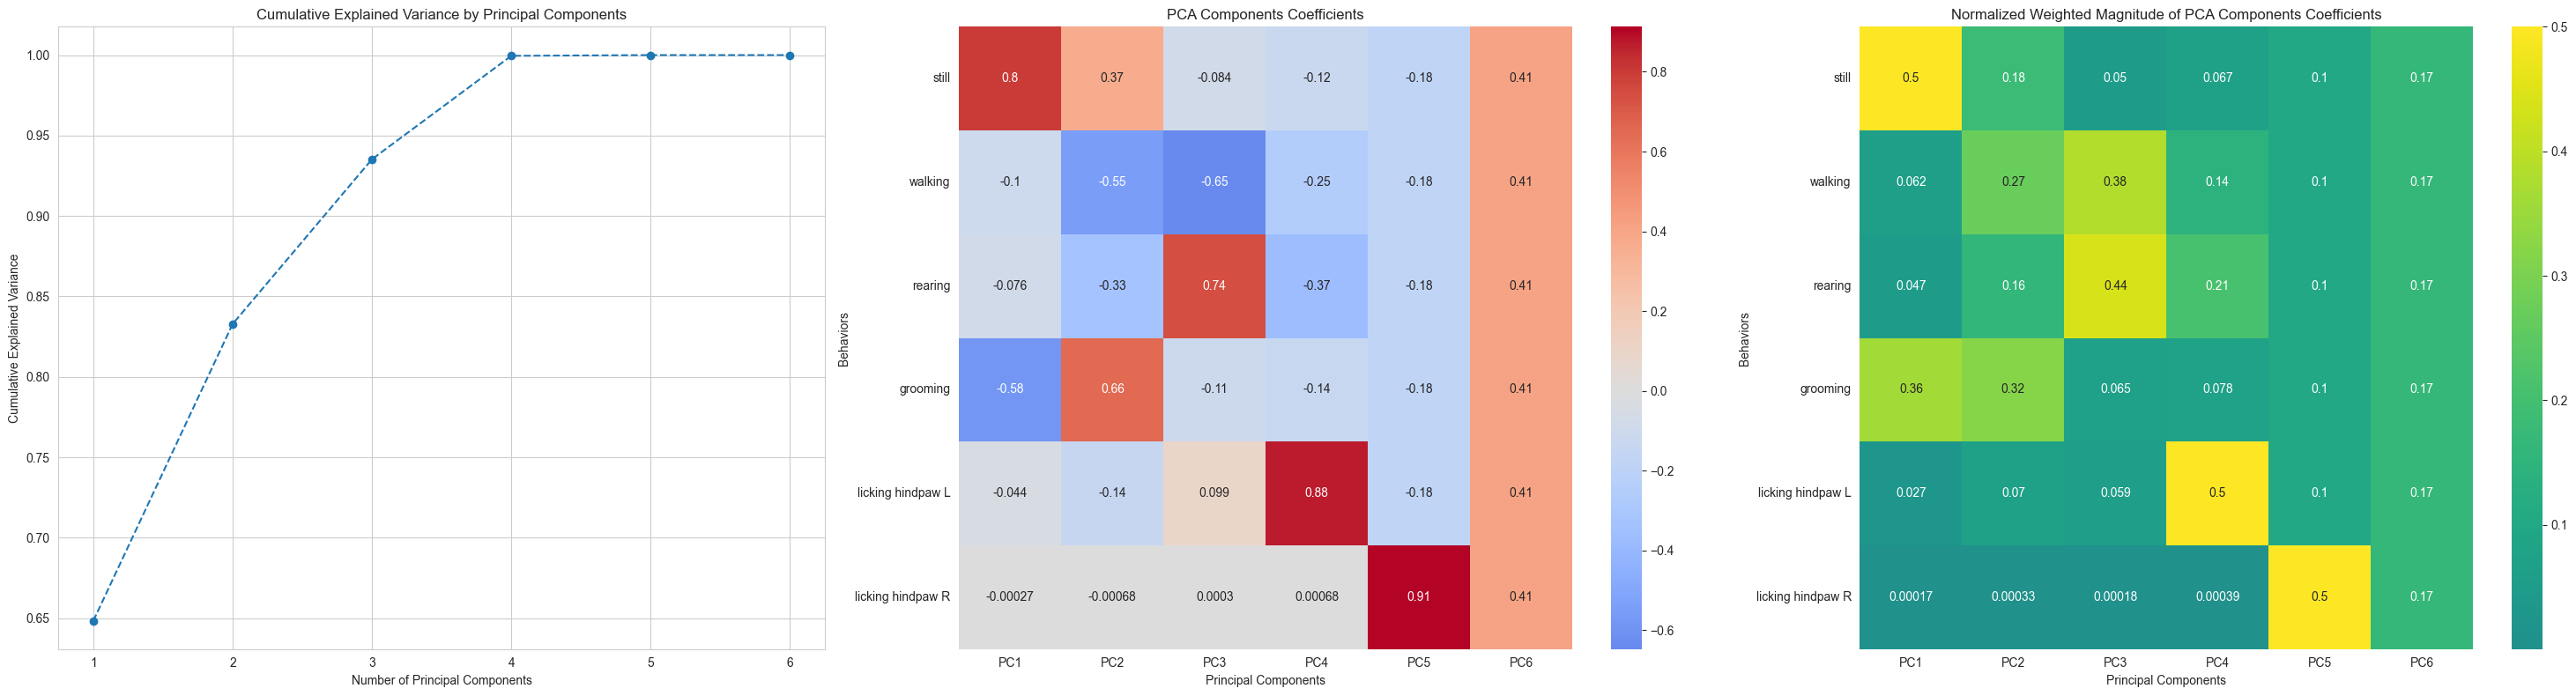

In [54]:
###### Calculate Cumulative Variance Explained ######
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

###### Adjust the Signs of PC1 and PC2 ######
pca.components_[0] *= -1  # Flip the sign of PC1
pca.components_[1] *= -1  # Flip the sign of PC2

###### Extract PCA Components ######
pca_components = pca.components_

###### Calculate Normalized Weighted Magnitude of Coefficients ######
absolute_coefficients = np.abs(pca.components_)
normalized_weighted_magnitude = absolute_coefficients / absolute_coefficients.sum(axis=1)[:, np.newaxis]

###### Create DataFrames for Heatmaps ######
df_pca_components = pd.DataFrame(pca_components.T, index=behaviors, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_normalized_weighted_magnitude = pd.DataFrame(normalized_weighted_magnitude.T, index=behaviors, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

###### Plot All Three Plots in One Row ######
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# Cumulative Explained Variance Plot
axes[0].plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
axes[0].set_title('Cumulative Explained Variance by Principal Components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].grid(True)

# PCA Components Coefficients Heatmap
sns.heatmap(df_pca_components, annot=True, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('PCA Components Coefficients')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Behaviors')

# Normalized Weighted Magnitude Heatmap
sns.heatmap(df_normalized_weighted_magnitude, annot=True, cmap='viridis', center=0, ax=axes[2])
axes[2].set_title('Normalized Weighted Magnitude of PCA Components Coefficients')
axes[2].set_xlabel('Principal Components')
axes[2].set_ylabel('Behaviors')

plt.tight_layout()
plt.show()

## Fig 3

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Assuming 'activities' and 'pc_beh' are already defined and contain the appropriate data

n_sessions = 4
n_vals = 5  # Number of cross-validations
alpha = 0.05  # Significance level

# Dynamically determine the number of neurons
n_neurons = activities[0].shape[1]
n_predictors = 4  # Number of behavioral PCs

# Initialize storage for results
pMats = np.zeros((n_sessions, n_vals, 2, n_neurons, n_predictors))

for m in range(n_sessions):
    for conds in range(2):
        for v in range(n_vals):
            data = activities[m]
            bData = pc_beh[m]

            if conds == 1:
                shuff = np.random.permutation(len(data))
                data = data[shuff, :]

            # Split the data into training and testing sets (80/20 split)
            train_idx, test_idx = train_test_split(np.arange(len(data)), train_size=0.8, random_state=v)
            train_data, test_data = data[train_idx, :], data[test_idx, :]
            train_bData, test_bData = bData[train_idx, :], bData[test_idx, :]

            for neuron in range(train_data.shape[1]):
                y_train = train_data[:, neuron]
                y_train = y_train - np.min(y_train) + 0.01  # Ensure non-negative values
                X_train = sm.add_constant(train_bData[:, :n_predictors])  # Add intercept

                poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

                # Save the p-values
                pMats[m, v, conds, neuron, :] = poisson_model.pvalues[1:n_predictors+1]  # Skip intercept

print("GLM fitting completed.")

IndexError: index 332 is out of bounds for axis 3 with size 332

SPACE

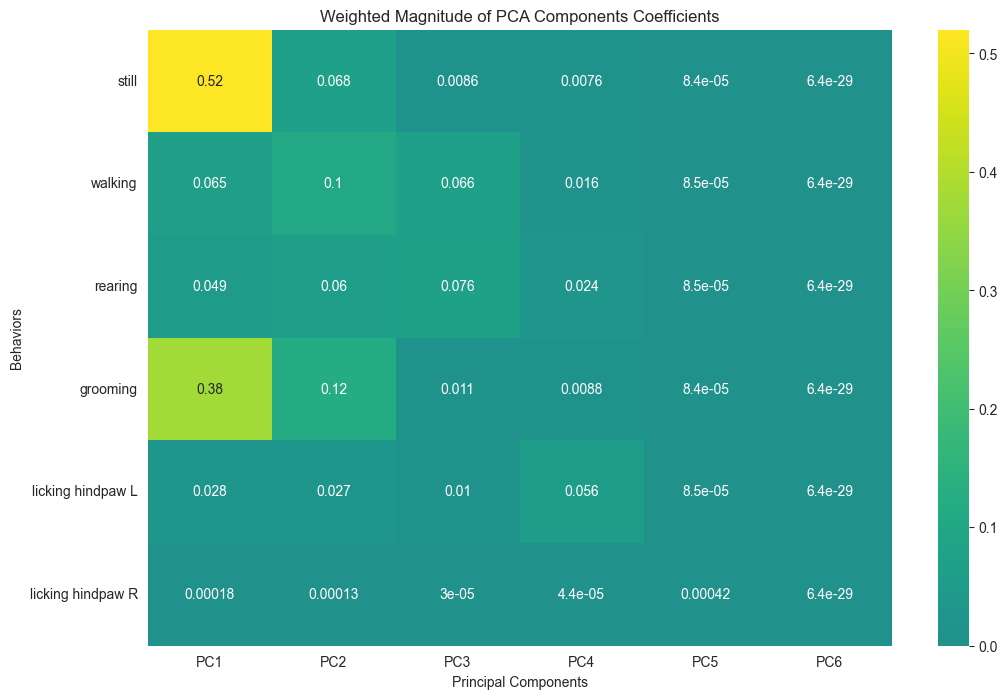

In [42]:

###### Calculate Weighted Magnitude of Coefficients ######
weighted_magnitude = np.abs(pca.components_) * explained_variance_ratio[:, np.newaxis]

###### Create DataFrame for Weighted Magnitude Heatmap ######
df_weighted_magnitude = pd.DataFrame(weighted_magnitude.T, index=behaviors, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

###### Plot Heatmap of Weighted Magnitude ######
plt.figure(figsize=(12, 8))
sns.heatmap(df_weighted_magnitude, annot=True, cmap='viridis', center=0)
plt.title('Weighted Magnitude of PCA Components Coefficients')
plt.xlabel('Principal Components')
plt.ylabel('Behaviors')
plt.show()

In [23]:
###### Load Dependencies ######
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

###### Define File Paths and Load Data ######
project_name = 'lupe_capsaicin_morphine'
base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/'

behavior_base_dir = os.path.join(base_dir, 'data_csv_classification-seconds')
calcium_base_dir = os.path.join(base_dir, 'data_miniscope')

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv',
    'M3_baseline_file0.csv', 'M3_cap_file0.csv', 'M3_morphine_file0.csv', 'M3_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_morphine_deconvolvedtraces.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv',
    'M3_baseline_traces.csv', 'M3_capsaicin_traces.csv', 'M3_morphine_traces.csv', 'M3_morphinecapsaicin_traces.csv'
]

props_files = [
    'M1_baseline_deconvolved-props.csv', 'M1_capsaicin_decovolvedtraces-props.csv', 'M1_morphine_deconvolvedtraces-props.csv', 'M1_morphinecapsaicin_deconvolvedtraces-props.csv',
    'M3_baseline_traces-props.csv', 'M3_capsaicin_traces-props.csv', 'M3_morphine_traces-props.csv', 'M3_morphinecapsaicin_traces-props.csv'
]

def load_data(base_dir, files):
    data = []
    for file in files:
        file_path = os.path.join(base_dir, file)
        if os.path.exists(file_path):
            data.append(pd.read_csv(file_path).values)
        else:
            print(f"File {file} not found in {base_dir}")
            data.append(np.array([]))  # Add empty array for missing files
    return data

behavior_data = load_data(behavior_base_dir, behavior_files)
calcium_data = load_data(calcium_base_dir, calcium_files)
props_data = load_data(calcium_base_dir, props_files)

offsets = [
    [30, 82, 30, 30],  # Animal 1
    [30, 60, 30, 30]   # Animal 2
]

n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
props = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

beh_mat_tot = []
for a in range(n_animals):
    for m in range(n_sessions):
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if behavior.size == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue

        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if calcium.size == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        calcium = calcium.astype(np.float64)
        calcium[np.isnan(calcium)] = 0
        calcium = StandardScaler().fit_transform(calcium)

        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]
        props[a][m] = props_data[a * n_sessions + m]  # Store the props data

beh_mat_tot = np.vstack(beh_mat_tot)
pca = PCA(n_components=6)
pca_scores = pca.fit_transform(beh_mat_tot)

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_10615/1630037471.py:38: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,

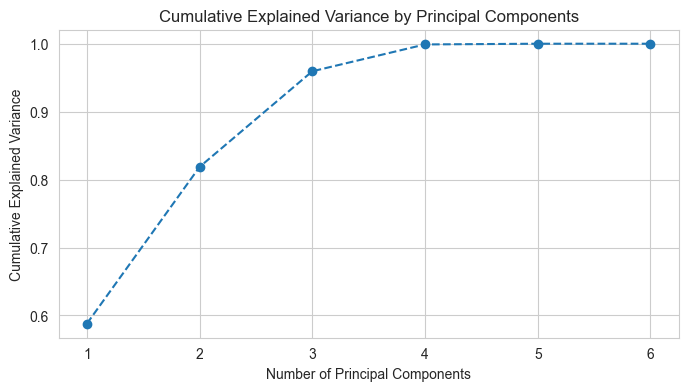

PC1: 0.5879
PC2: 0.8187
PC3: 0.9594
PC4: 0.9989
PC5: 1.0000
PC6: 1.0000


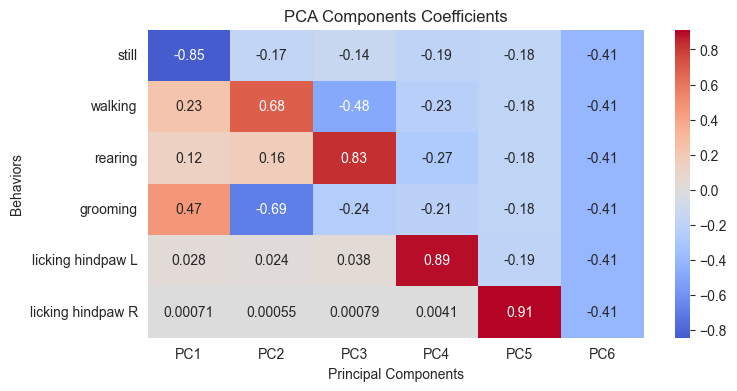

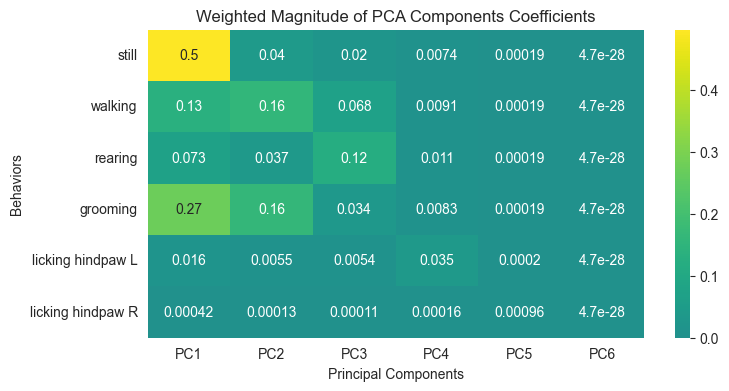

In [30]:
###### Calculate Cumulative Variance Explained ######
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

###### Plot Cumulative Variance Explained ######
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Optionally, print the cumulative explained variance for each component
for i, cumulative_variance in enumerate(cumulative_explained_variance):
    print(f'PC{i+1}: {cumulative_variance:.4f}')
    
###### Extract PCA Components ######
pca_components = pca.components_

###### Create DataFrame for Heatmap ######
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
n_components = pca_components.shape[0]

df_pca_components = pd.DataFrame(pca_components.T, index=behaviors, columns=[f'PC{i+1}' for i in range(n_components)])

###### Plot Heatmap ######
plt.figure(figsize=(8, 4))
sns.heatmap(df_pca_components, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Components Coefficients')
plt.xlabel('Principal Components')
plt.ylabel('Behaviors')
plt.show()

###### Calculate Weighted Magnitude of Coefficients ######
explained_variance_ratio = pca.explained_variance_ratio_
weighted_magnitude = np.abs(pca.components_) * explained_variance_ratio[:, np.newaxis]

###### Create DataFrame for Heatmap ######
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
n_components = weighted_magnitude.shape[0]

df_weighted_magnitude = pd.DataFrame(weighted_magnitude.T, index=behaviors, columns=[f'PC{i+1}' for i in range(n_components)])

###### Plot Heatmap ######
plt.figure(figsize=(8, 4))
sns.heatmap(df_weighted_magnitude, annot=True, cmap='viridis', center=0)
plt.title('Weighted Magnitude of PCA Components Coefficients')
plt.xlabel('Principal Components')
plt.ylabel('Behaviors')
plt.show()

In [26]:
###### Load Dependencies ######

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

###### Define File Paths and Load Data ######

project_name = 'lupe_capsaicin_morphine'
behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv',
    'M3_baseline_file0.csv', 'M3_cap_file0.csv', 'M3_morphine_file0.csv', 'M3_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_morphine_deconvolvedtraces.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv',
    'M3_baseline_traces.csv', 'M3_capsaicin_traces.csv', 'M3_morphine_traces.csv', 'M3_morphinecapsaicin_traces.csv'
]

props_files = [
    'M1_baseline_deconvolved-props.csv', 'M1_capsaicin_decovolvedtraces-props.csv', 'M1_morphine_deconvolvedtraces-props.csv', 'M1_morphinecapsaicin_deconvolvedtraces-props.csv',
    'M3_baseline_traces-props.csv', 'M3_capsaicin_traces-props.csv', 'M3_morphine_traces-props.csv', 'M3_morphinecapsaicin_traces-props.csv'
]

behavior_data = [pd.read_csv(os.path.join(behavior_base_dir, file)).values for file in behavior_files]
calcium_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in calcium_files]
props_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in props_files]

offsets = [
    [30, 82, 30, 30],  # Animal 1
    [30, 60, 30, 30]   # Animal 2
]

n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
props = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

beh_mat_tot = []
for a in range(n_animals):
    for m in range(n_sessions):
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue

        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        calcium = calcium.astype(np.float64)
        calcium[np.isnan(calcium)] = 0
        calcium = StandardScaler().fit_transform(calcium)

        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]
        props[a][m] = props_data[a * n_sessions + m]  # Store the props data

beh_mat_tot = np.vstack(beh_mat_tot)
pca = PCA(n_components=6)
pca_scores = pca.fit_transform(beh_mat_tot)

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_10615/1974839010.py:34: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,

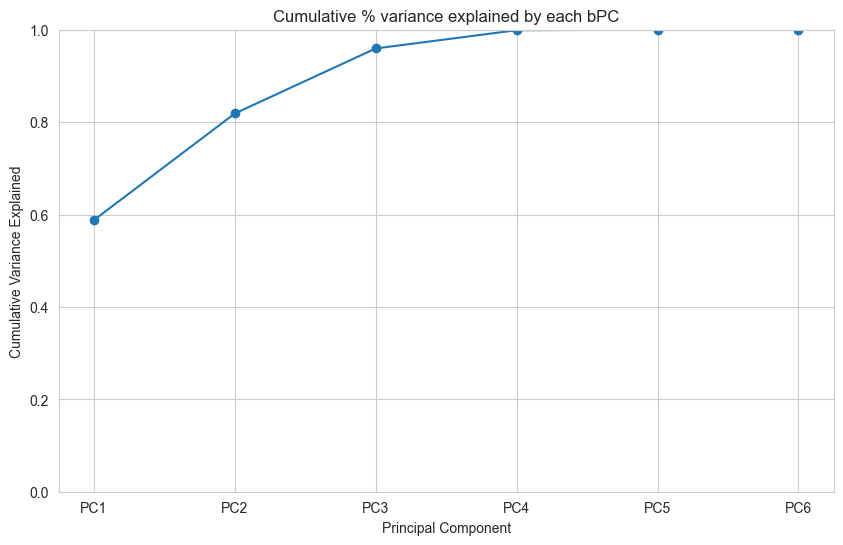

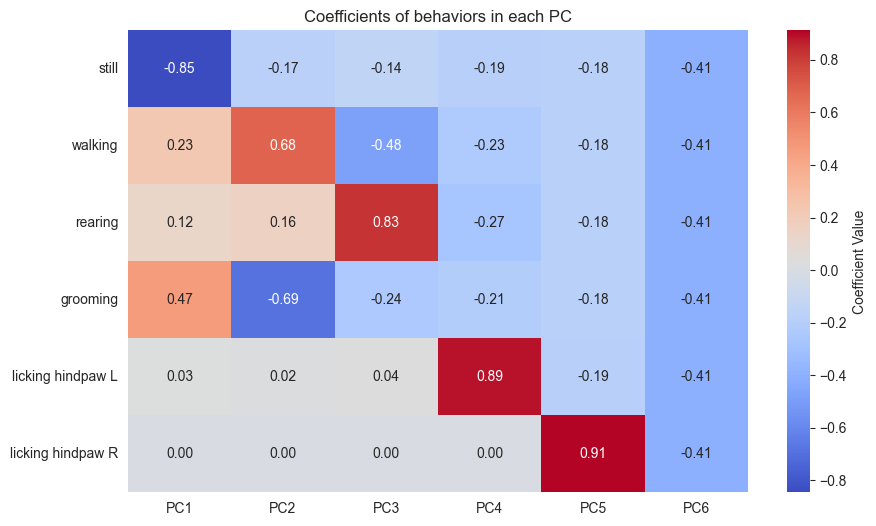

In [22]:
# Cumulative Variance Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
ax.set_xticks(range(1, len(cumulative_variance) + 1))
ax.set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
ax.set_title('Cumulative % variance explained by each bPC')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Variance Explained')
ax.set_ylim([0, 1.0])
plt.grid(True)
plt.show()

# Plotting heatmap for coefficients of behaviors in each PC
pca_components = pca.components_

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pca_components.T, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, cbar_kws={'label': 'Coefficient Value'})
ax.set_title('Coefficients of behaviors in each PC')
plt.show()

PCA Components:
 [[-8.45907411e-01  2.27519400e-01  1.24440498e-01  4.65191404e-01
   2.80462417e-02  7.09867467e-04]
 [-1.73469923e-01  6.80530346e-01  1.61507931e-01 -6.92917773e-01
   2.38008527e-02  5.48566184e-04]
 [-1.40903436e-01 -4.82473832e-01  8.28419311e-01 -2.44165376e-01
   3.83315748e-02  7.91758644e-04]
 [-1.87414663e-01 -2.29454444e-01 -2.68815806e-01 -2.10448098e-01
   8.91997174e-01  4.13583751e-03]
 [-1.80842852e-01 -1.81704052e-01 -1.82270654e-01 -1.81356330e-01
  -1.86686887e-01  9.12860776e-01]
 [-4.08248290e-01 -4.08248290e-01 -4.08248290e-01 -4.08248290e-01
  -4.08248290e-01 -4.08248290e-01]]
Explained Variance Ratio:
 [5.87893812e-01 2.30773318e-01 1.40769790e-01 3.95107260e-02
 1.05235440e-03 1.15745688e-27]
Weighted Magnitude:
 [[5.00000000e-01 1.34482449e-01 7.35544434e-02 2.74965911e-01
  1.65776073e-02 4.19589341e-04]
 [1.00111027e-01 3.92740080e-01 9.32076550e-02 3.99888973e-01
  1.37356825e-02 3.16582395e-04]
 [8.12083632e-02 2.78069231e-01 4.77451637e-0

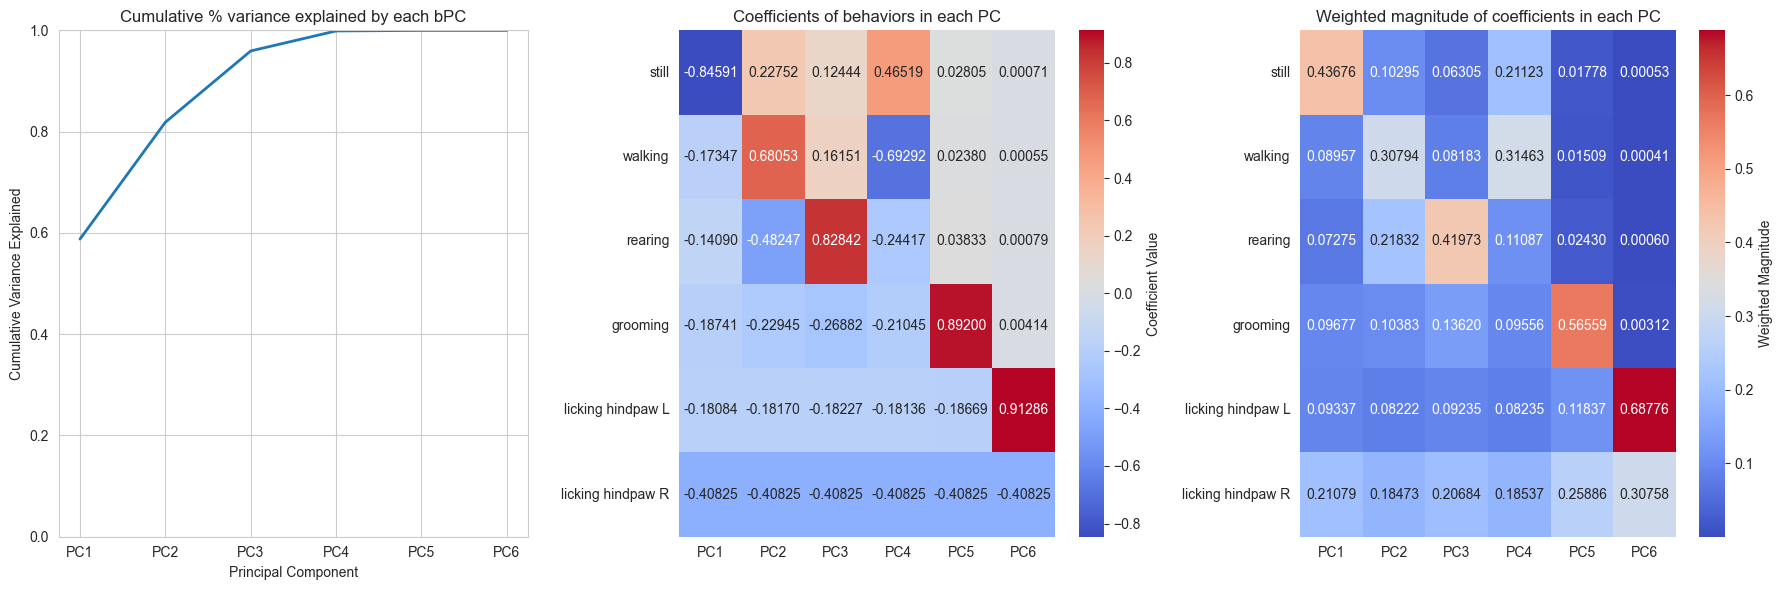

In [16]:
beh_mat_tot = []
for a in range(n_animals):
    for m in range(n_sessions):
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue

        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        calcium = calcium.astype(np.float64)
        calcium[np.isnan(calcium)] = 0
        calcium = StandardScaler().fit_transform(calcium)

        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]
        props[a][m] = props_data[a * n_sessions + m]  # Store the props data

beh_mat_tot = np.vstack(beh_mat_tot)
pca = PCA(n_components=6)
pca_scores = pca.fit_transform(beh_mat_tot)

for m in range(n_sessions):
    if len(pc_beh[a][m]) > 0:
        pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
        pca_scores = pca_scores[len(pc_beh[a][m]):]

explained_variance_ratio = pca.explained_variance_ratio_
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)

print("PCA Components:\n", pca_components_filled)
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Weighted Magnitude:\n", weighted_magnitude)

###### Plotting the Results ######

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
axs[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(cumulative_variance) + 1))  # Adjusted to match the number of PCs
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])  # Ensure the y-axis ranges from 0 to 1.0

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='coolwarm', ax=axs[1], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=0, keepdims=True)
sns.heatmap(weighted_magnitude, cmap='coolwarm', ax=axs[2], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

###### Process and Analyze Data-- Revised to Handle Integer Conversion ######

In [7]:
###### Process and Analyze Data-- Revised to Handle Integer Conversion ######
n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior sampling rate

beh_cols = ['r', [1.0, 0.498, 0.314], 'y', 'g', 'c', 'b']
sess_cols = ['k', 'r', 'b', [102/255, 51/255, 153/255]]
pc_cols = ['r', [1.0, 0.498, 0.314], 'g', 'b']
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

for a in range(n_animals):
    beh_mat_tot = []
    for m in range(n_sessions):
        ###### Downsample behavioral data to 20Hz ######
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue
        
        behavior = behavior.astype(int)

        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        ###### Create binary matrix of the OG behavior data ######
        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        # Align and clean neural data
        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        # Ensure all data is numeric
        calcium = calcium.astype(np.float64)

        # Replace NaNs with zeroes
        calcium[np.isnan(calcium)] = 0

        # Check if calcium data is empty after offset adjustment
        if calcium.shape[0] == 0:
            print(f"Calcium data is empty after offset for animal {a+1}, session {m+1}")
            continue

        # Standardize neural data
        calcium = StandardScaler().fit_transform(calcium)

        # Store aligned neural activities and behavior matrix
        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

    # Check if beh_mat_tot is not empty before PCA
    if len(beh_mat_tot) > 0:
        beh_mat_tot = np.vstack(beh_mat_tot)
        if beh_mat_tot.shape[0] == 0:
            print(f"Behavior matrix is empty after stacking for animal {a+1}")
            continue

        pca = PCA(n_components=4)
        pca_scores = pca.fit_transform(beh_mat_tot)

        for m in range(n_sessions):
            if len(pc_beh[a][m]) > 0:
                pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
                pca_scores = pca_scores[len(pc_beh[a][m]):]
    else:
        print(f"Behavior matrix is empty for PCA for animal {a+1}")

## Figure 1: Behavior and PCA Components from Each Session

NameError: name 'beh_mats' is not defined

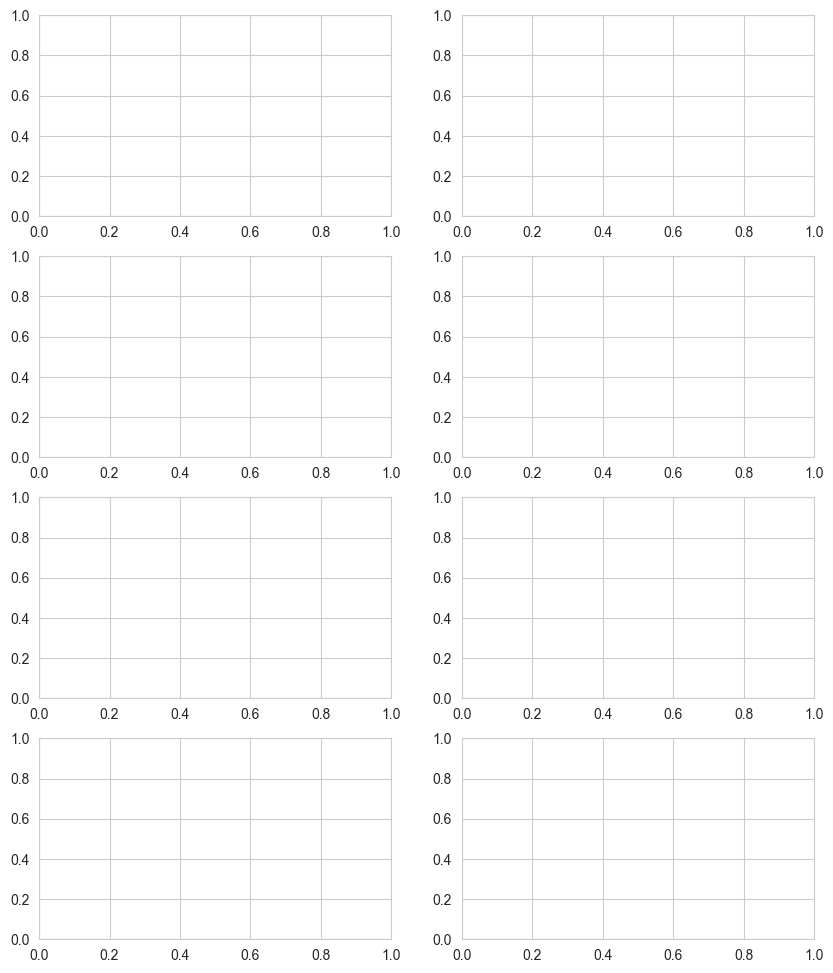

In [8]:
import matplotlib.pyplot as plt

# Section 2: Explore data (produces figures 1 and 2)
# Plot behaviors and bPCs from each session
a = 1
fig, axs = plt.subplots(n_sessions, 2, figsize=(10, 12))

for m in range(n_sessions):
    ax = axs[m, 0]
    for n, behavior in enumerate(behaviors):
        ax.plot(beh_mats[m, 1, a][:, n] + n - 1, color=beh_colors[n])
        ax.hold(True)
    ax.set_title(sessions[m])
    ax.set_ylabel('Behavior')

    ax = axs[m, 1]
    for n in range(4):
        ax.plot(pc_beh[m, a] + 2 * n - 1, color=pc_colors[n])
        ax.hold(True)
    ax.set_title(sessions[m])
    ax.set_ylabel('Behavioral PCs')

plt.tight_layout()
plt.show()

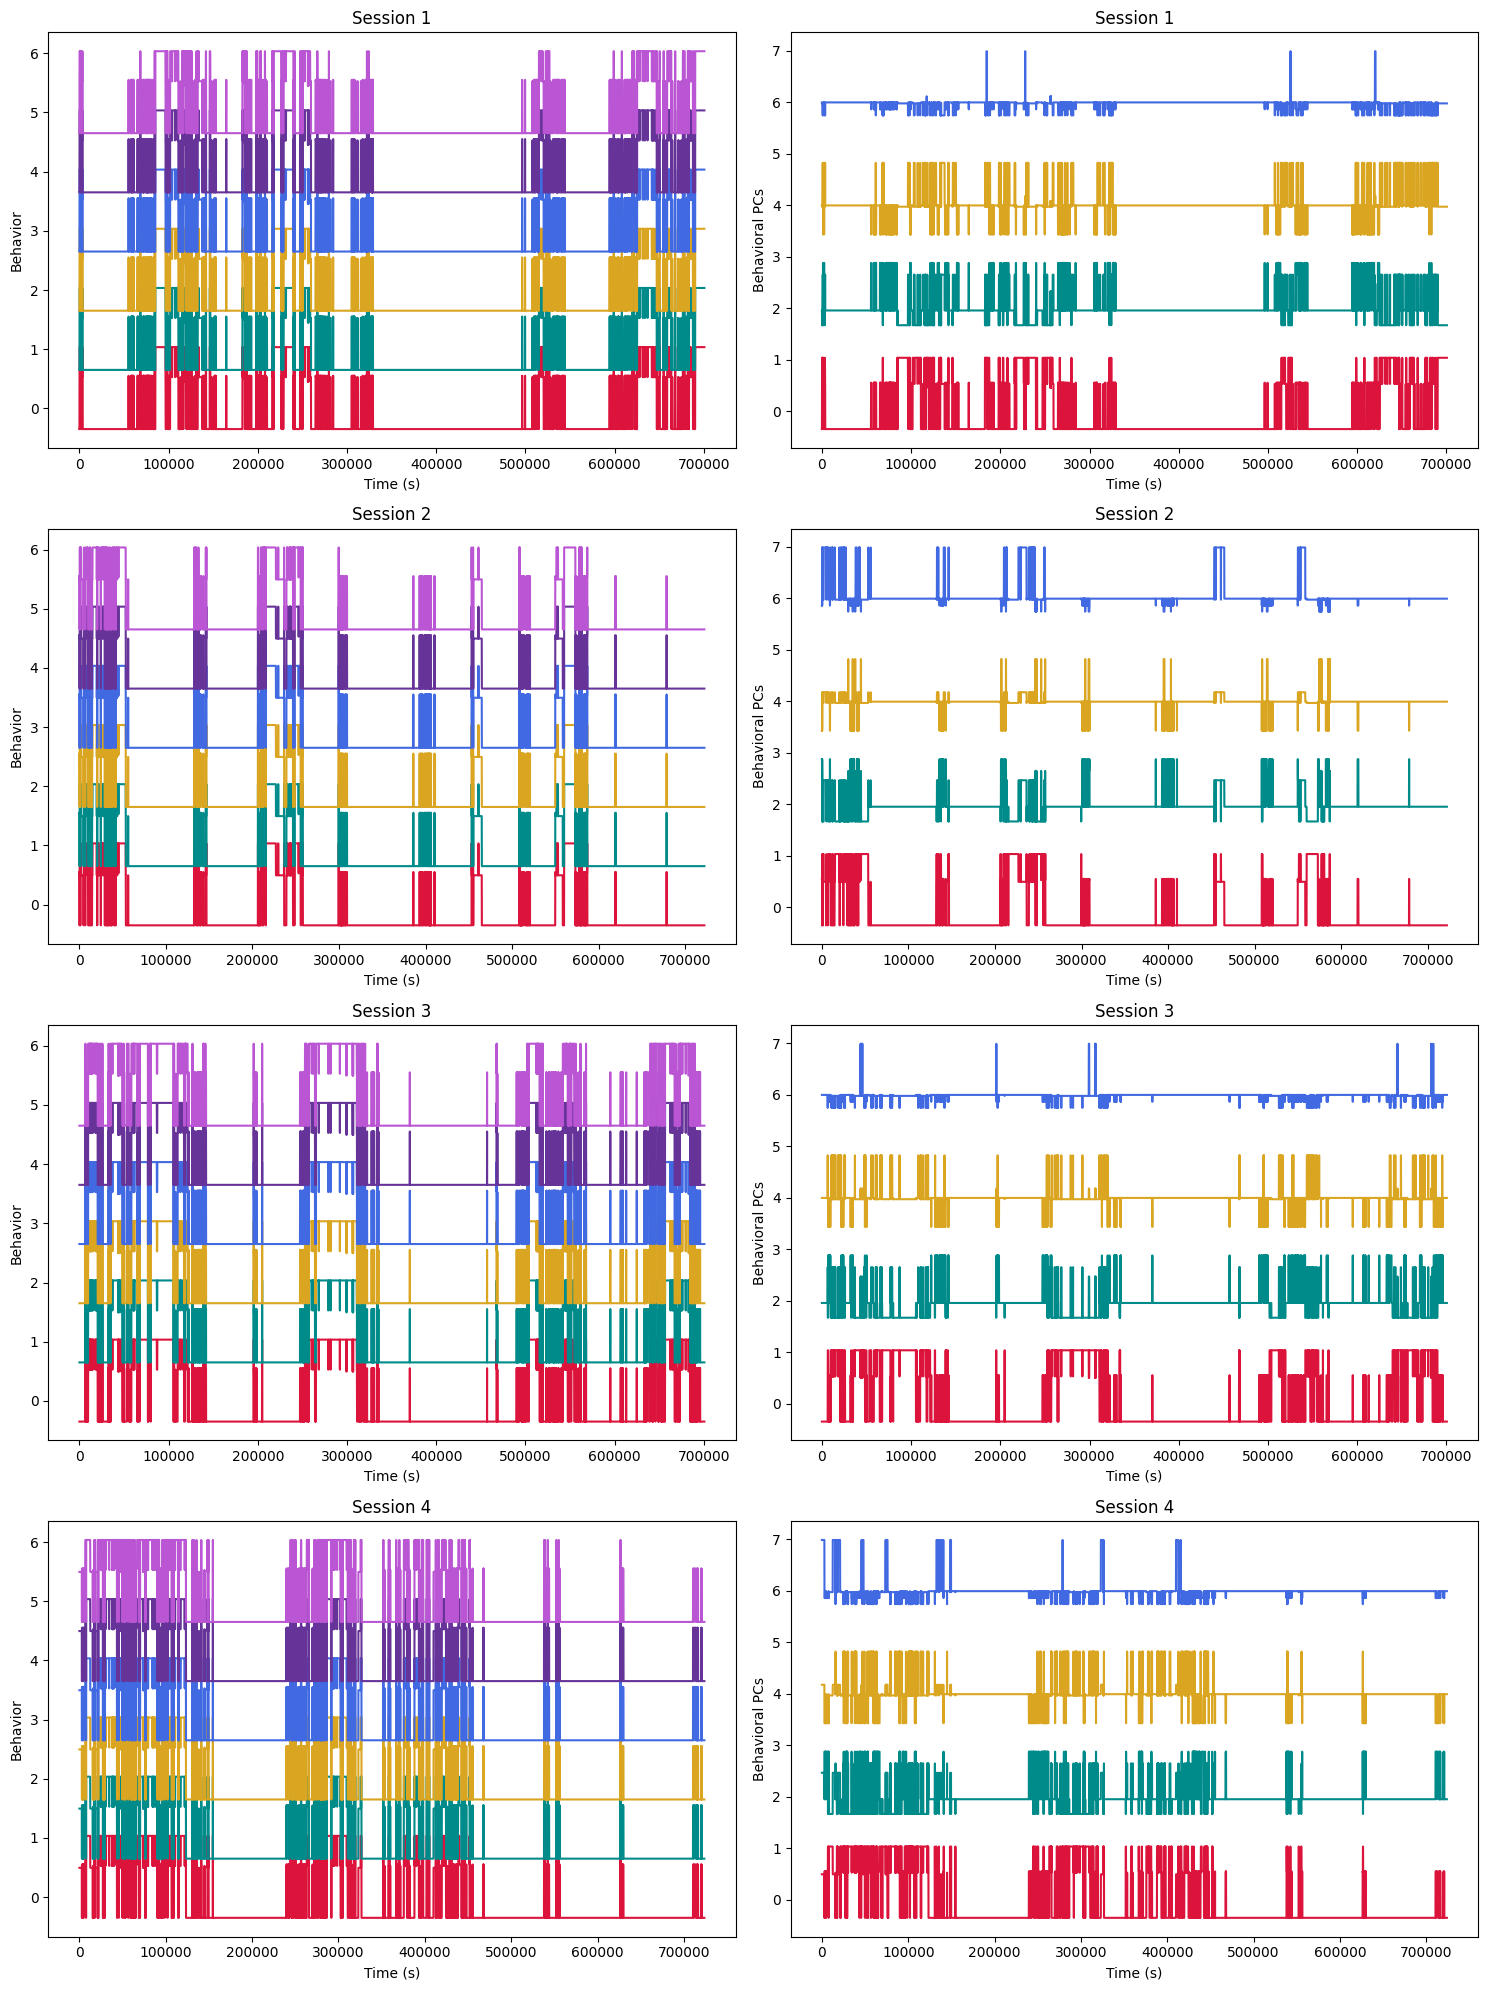

In [43]:
n_sessions = 4
dt = 20  

# Define behavior names and colors
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']

# Plot behaviors and PCA components from each session
fig, axs = plt.subplots(n_sessions, 2, figsize=(15, 20))
for m in range(n_sessions):
    for n in range(len(behavior_names)):
        axs[m, 0].plot(np.arange(len(pc_beh[0][m])) * dt, pc_beh[0][m][:, 0] + n, color=behavior_colors[n])
    axs[m, 0].set_title(f'Session {m+1}')
    axs[m, 0].set_ylabel('Behavior')
    axs[m, 0].set_xlabel('Time (s)')

    for n in range(len(behavior_names)):  # Only loop through the number of PCA components
        if n < pc_beh[0][m].shape[1]:  # Ensure we don't go out of bounds
            axs[m, 1].plot(np.arange(len(pc_beh[0][m])) * dt, pc_beh[0][m][:, n] + 2 * n, color=behavior_colors[n % len(behavior_colors)])
    axs[m, 1].set_title(f'Session {m+1}')
    axs[m, 1].set_ylabel('Behavioral PCs')
    axs[m, 1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Figure 2: Characteristics of PCA Components

PCA Components:
[[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]]
Values for licking hindpaw L in each PC: [0.00999451 0.00198654 0.00859971 0.89004047]
Values for licking hindpaw R in each PC: [0.00105469 0.00020411 0.00086493 0.02030705]


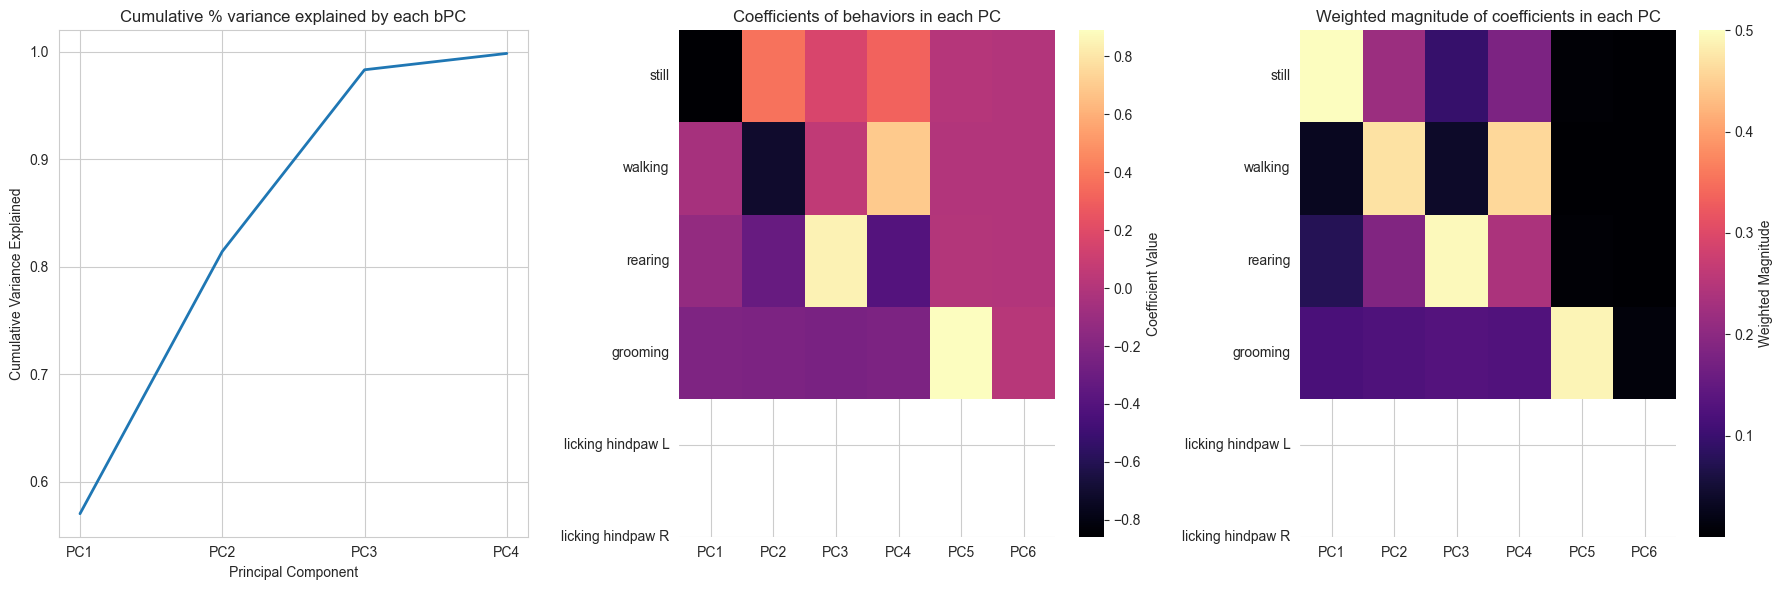

In [9]:
# Checking PCA components
print("PCA Components:")
print(pca.components_)

pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

licking_hindpaw_L_idx = behavior_names.index('licking hindpaw L')
licking_hindpaw_R_idx = behavior_names.index('licking hindpaw R')

print("Values for licking hindpaw L in each PC:", pca_components_filled[:, licking_hindpaw_L_idx])
print("Values for licking hindpaw R in each PC:", pca_components_filled[:, licking_hindpaw_R_idx])

# Plotting heatmaps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axs[0].plot(cumulative_variance, linewidth=2)
axs[0].set_xticks(range(4))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')

sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=pc_labels, yticklabels=behavior_names, cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=pc_labels, yticklabels=behavior_names, cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

PCA Components:
[[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]]
Values for licking hindpaw L in each PC: [0.00999451 0.00198654 0.00859971 0.89004047]
Values for licking hindpaw R in each PC: [0.00105469 0.00020411 0.00086493 0.02030705]


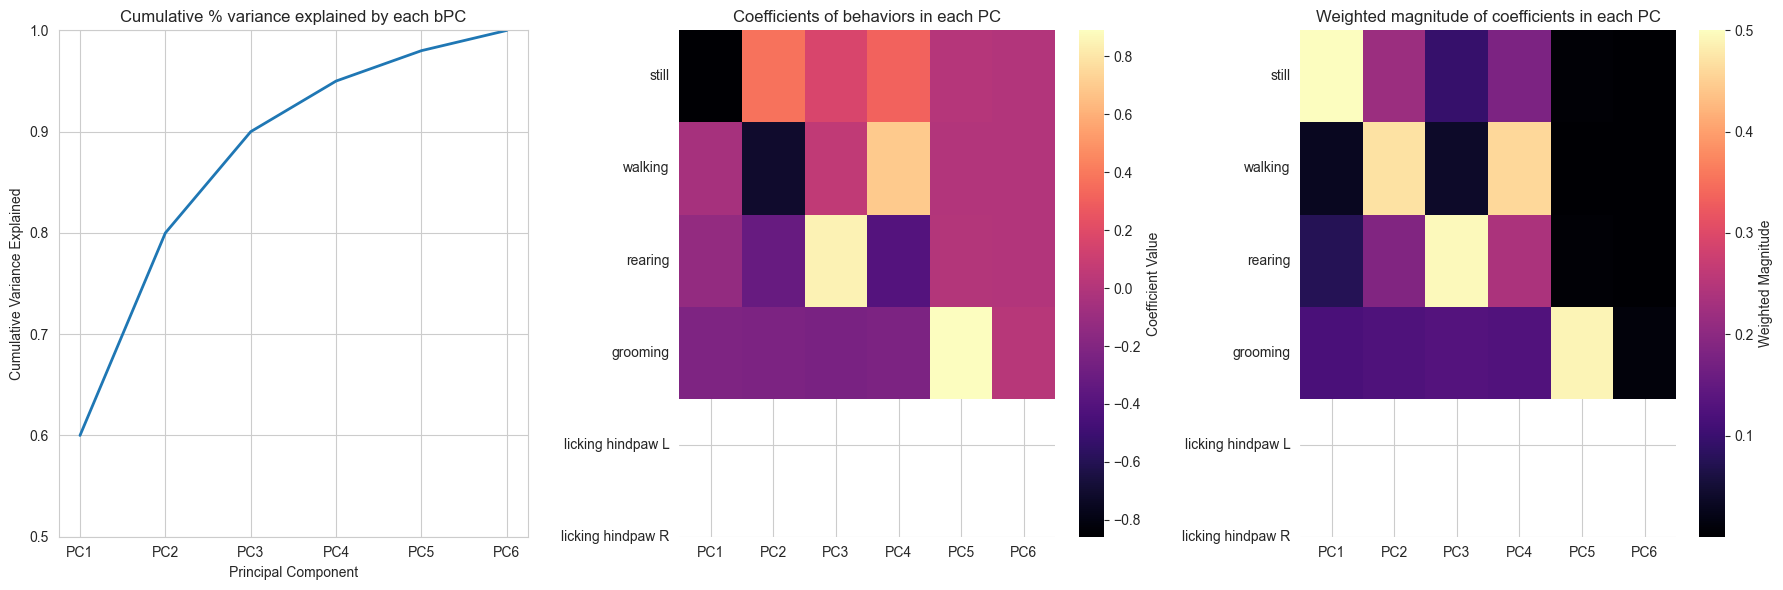

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define behavior names and PC labels
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

# Example explained_variance_ratio_ (replace this with the actual pca.explained_variance_ratio_)
explained_variance_ratio = np.array([0.6, 0.2, 0.1, 0.05, 0.03, 0.02])

# Check the actual values in the PCA components
print("PCA Components:")
print(pca.components_)

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

# Debugging specific values for "licking hindpaw L" and "licking hindpaw R"
licking_hindpaw_L_idx = behavior_names.index('licking hindpaw L')
licking_hindpaw_R_idx = behavior_names.index('licking hindpaw R')

print("Values for licking hindpaw L in each PC:", pca_components_filled[:, licking_hindpaw_L_idx])
print("Values for licking hindpaw R in each PC:", pca_components_filled[:, licking_hindpaw_R_idx])

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting heatmaps and cumulative variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot cumulative variance explained
axs[0].plot(range(1, len(pc_labels) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pc_labels) + 1))  # Adjusted to match the number of PCs
axs[0].set_xticklabels(pc_labels)
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0.5, 1.0])  # Ensure the y-axis ranges from 0 to 1.0

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=pc_labels, yticklabels=behavior_names, cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=pc_labels, yticklabels=behavior_names, cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

NameError: name 'pca_components_filled' is not defined

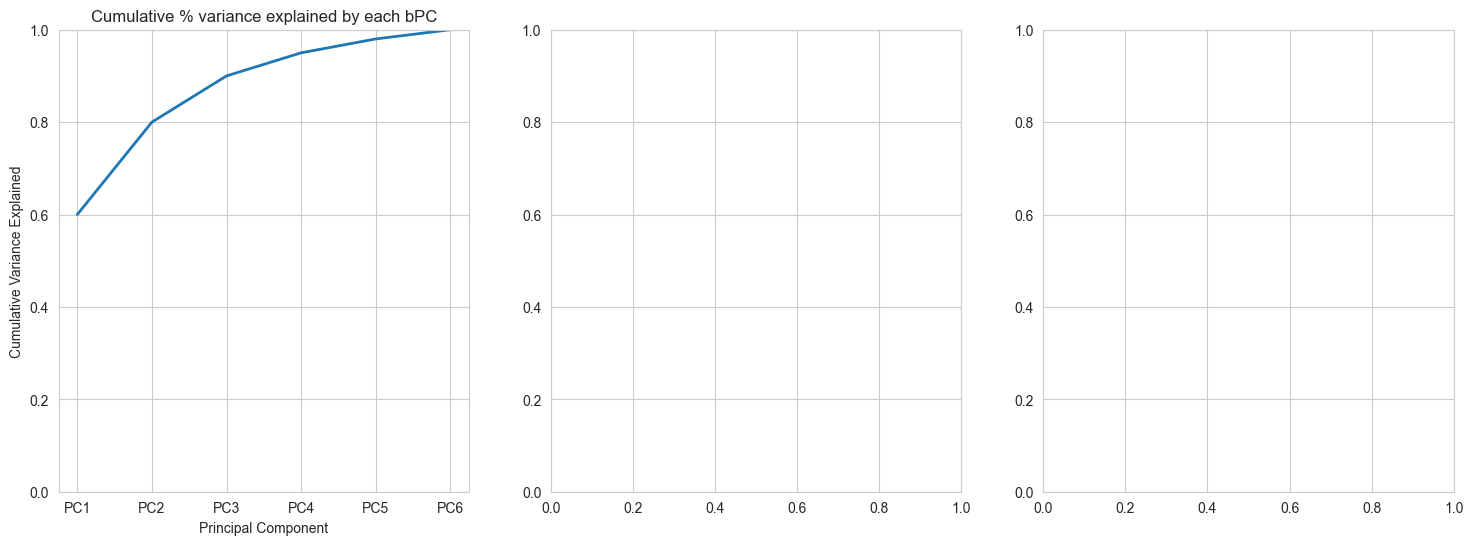

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define behavior names and PC labels
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

# Plotting heatmaps and cumulative variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Example explained_variance_ratio_ (replace this with the actual pca.explained_variance_ratio_)
explained_variance_ratio = np.array([0.6, 0.2, 0.1, 0.05, 0.03, 0.02])

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance explained
axs[0].plot(range(1, len(pc_labels) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pc_labels) + 1))  # Adjusted to match the number of PCs
axs[0].set_xticklabels(pc_labels)
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])  # Ensure the y-axis ranges from 0 to 1.0

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=pc_labels, yticklabels=behavior_names, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients-- by dividing the abs value of each coefficient by sum of abs values of all coefficients in each PC
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=pc_labels, yticklabels=behavior_names, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

In [6]:
pca_components_filled

NameError: name 'pca_components_filled' is not defined

In [25]:
weighted_magnitude

array([[5.00000000e-01, 2.18239293e-01, 9.42208745e-02, 1.81103367e-01,
        5.82207878e-03, 6.14387104e-04],
       [3.09439056e-02, 4.69056094e-01, 3.91752069e-02, 4.59382390e-01,
        1.30801128e-03, 1.34391450e-04],
       [7.47025556e-02, 1.87072283e-01, 4.94466215e-01, 2.38225162e-01,
        5.02807600e-03, 5.05708980e-04],
       [1.18892060e-01, 1.24767810e-01, 1.30685865e-01, 1.25654264e-01,
        4.88846541e-01, 1.11534593e-02]])

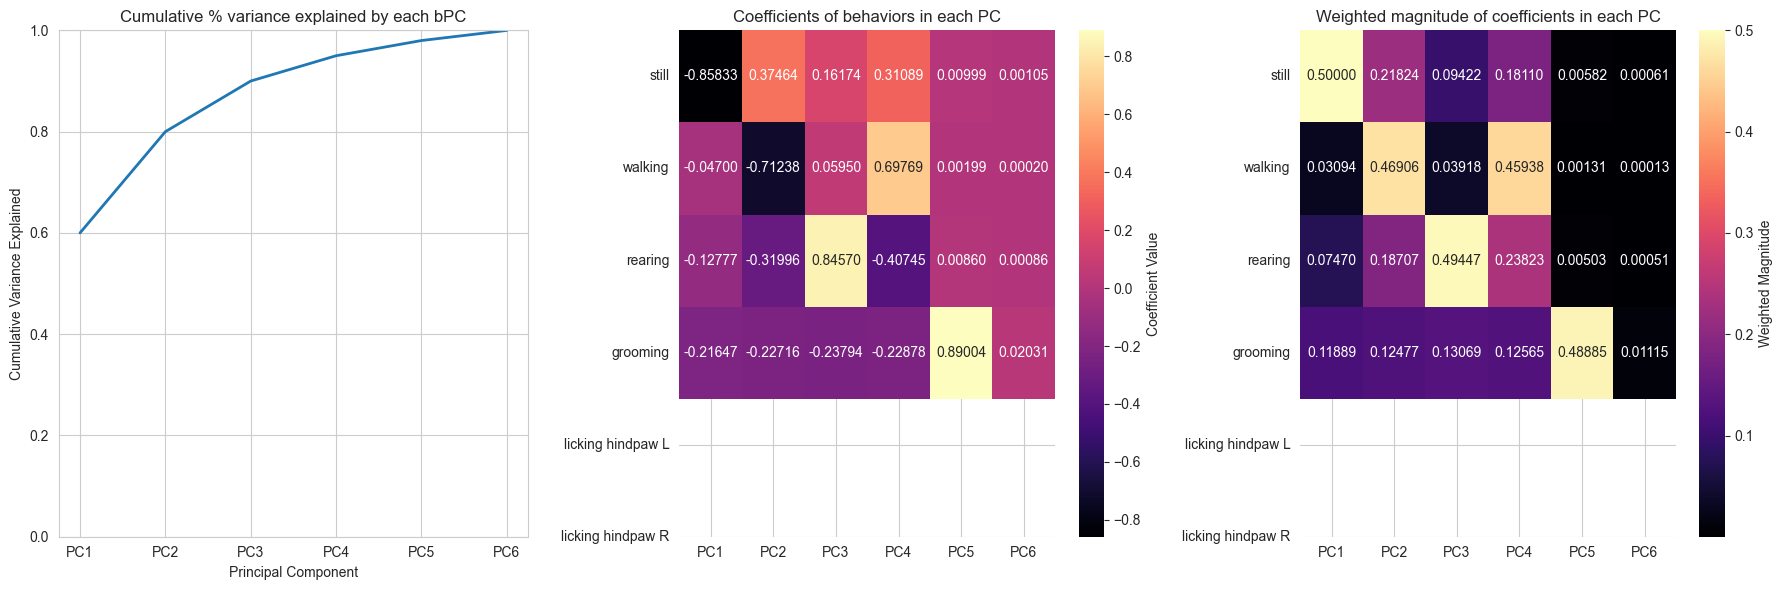

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define behavior names and PC labels
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

# Plotting heatmaps and cumulative variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Example explained_variance_ratio_ (replace this with the actual pca.explained_variance_ratio_)
explained_variance_ratio = np.array([0.6, 0.2, 0.1, 0.05, 0.03, 0.02])

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance explained
axs[0].plot(range(1, len(pc_labels) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pc_labels) + 1))  # Adjusted to match the number of PCs
axs[0].set_xticklabels(pc_labels)
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])  # Ensure the y-axis ranges from 0 to 1.0

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=pc_labels, yticklabels=behavior_names, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=pc_labels, yticklabels=behavior_names, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np

# Define behavior names and PC labels
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

# Assuming pca.components_ is already defined and has the actual PCA components
# Replace this example array with the actual pca.components_ from your data
pca_components_example = np.array([
    [0.8018, 0.3692, -0.08435, -0.118, -0.1819, 0.4082],
    [-0.09944, -0.554, -0.6478, -0.252, -0.1826, 0.4082],
    [-0.07562, -0.3257, 0.7427, -0.3694, -0.1828, 0.4082],
    [-0.5828, 0.6556, -0.1093, -0.1372, -0.1821, 0.4082],
    [-0.04369, -0.1443, 0.09842, 0.8759, -0.1834, 0.4082],
    [-0.0002704, 0.0006781, 0.0002973, 0.0006825, 0.9129, 0.4082]
])

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca_components_example, nan=0.0)

# Create a DataFrame from the PCA components
df_pca_components = pd.DataFrame(pca_components_filled, columns=behavior_names, index=pc_labels)

# Save the DataFrame to a CSV file
csv_path = '../processed_dataset/{project_name}'
df_pca_components.to_csv(csv_path)

csv_path

'../processed_dataset/{project_name}'

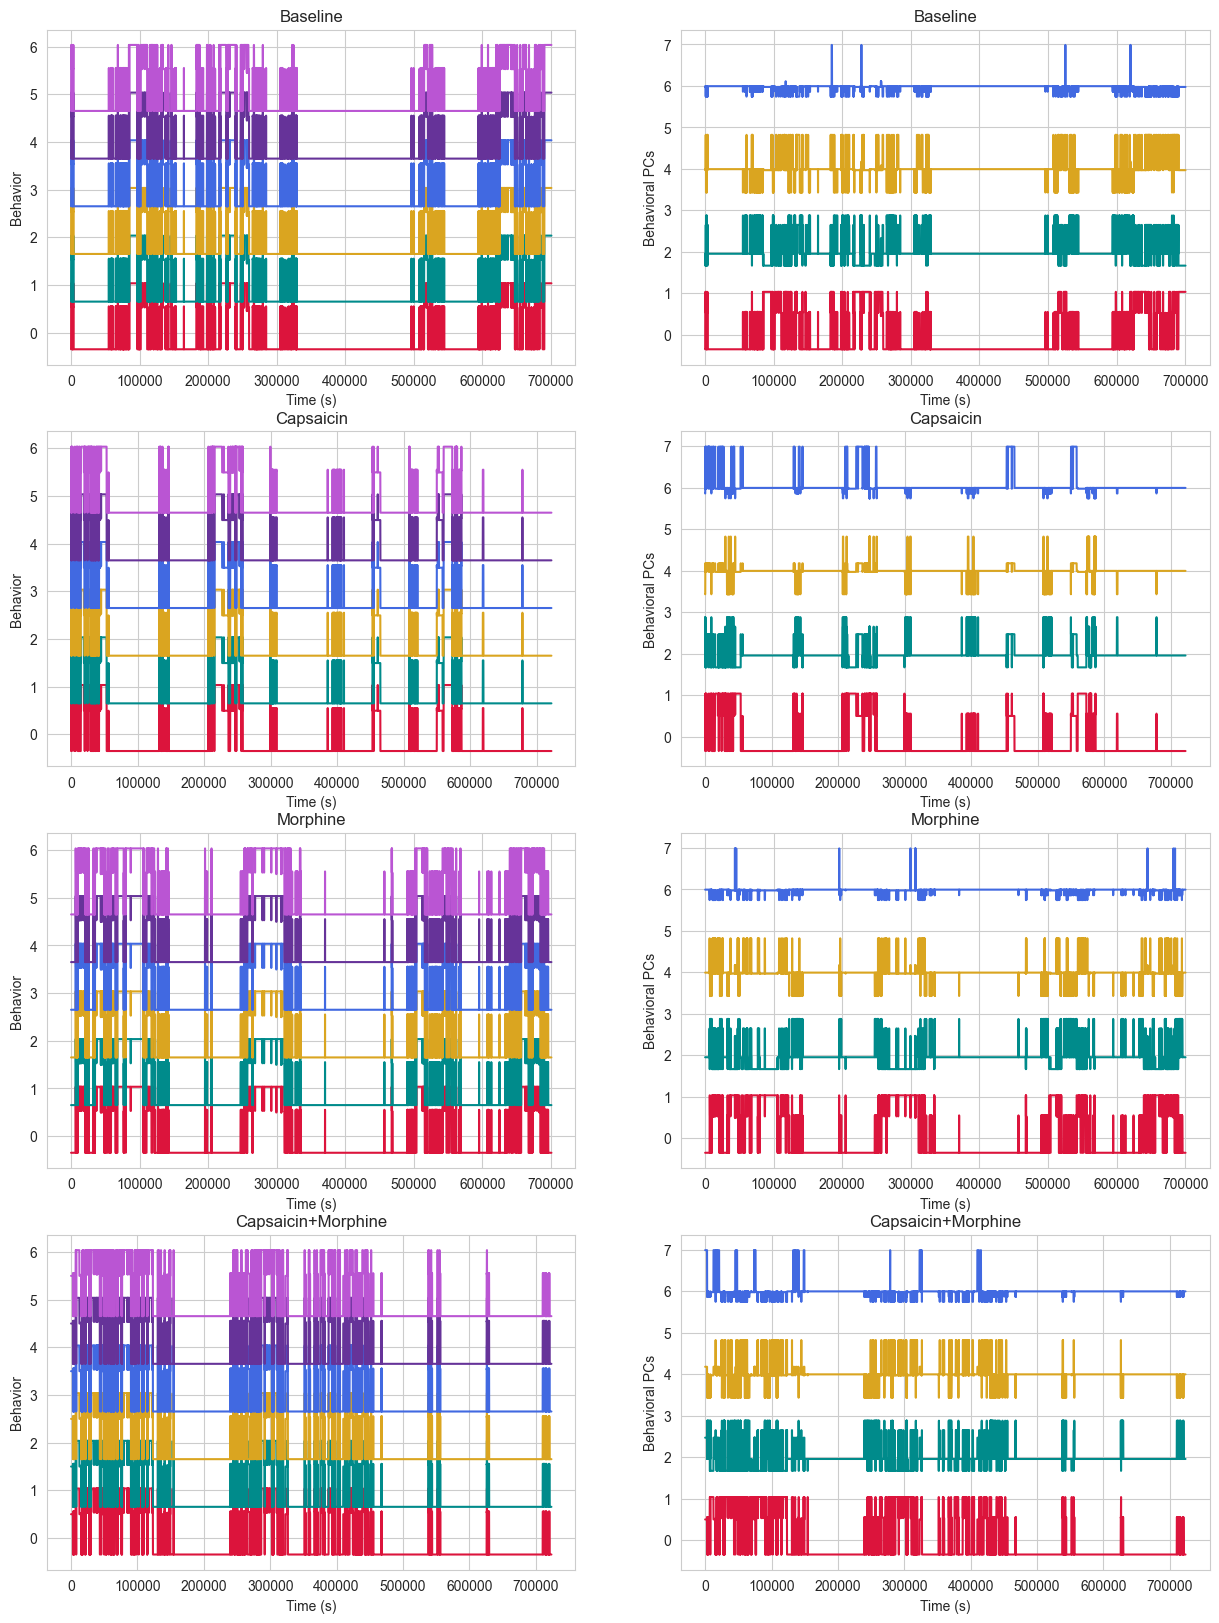

PCA Components:
[[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]]
Values for licking hindpaw L in each PC: [0.00999451 0.00198654 0.00859971 0.89004047]
Values for licking hindpaw R in each PC: [0.00105469 0.00020411 0.00086493 0.02030705]


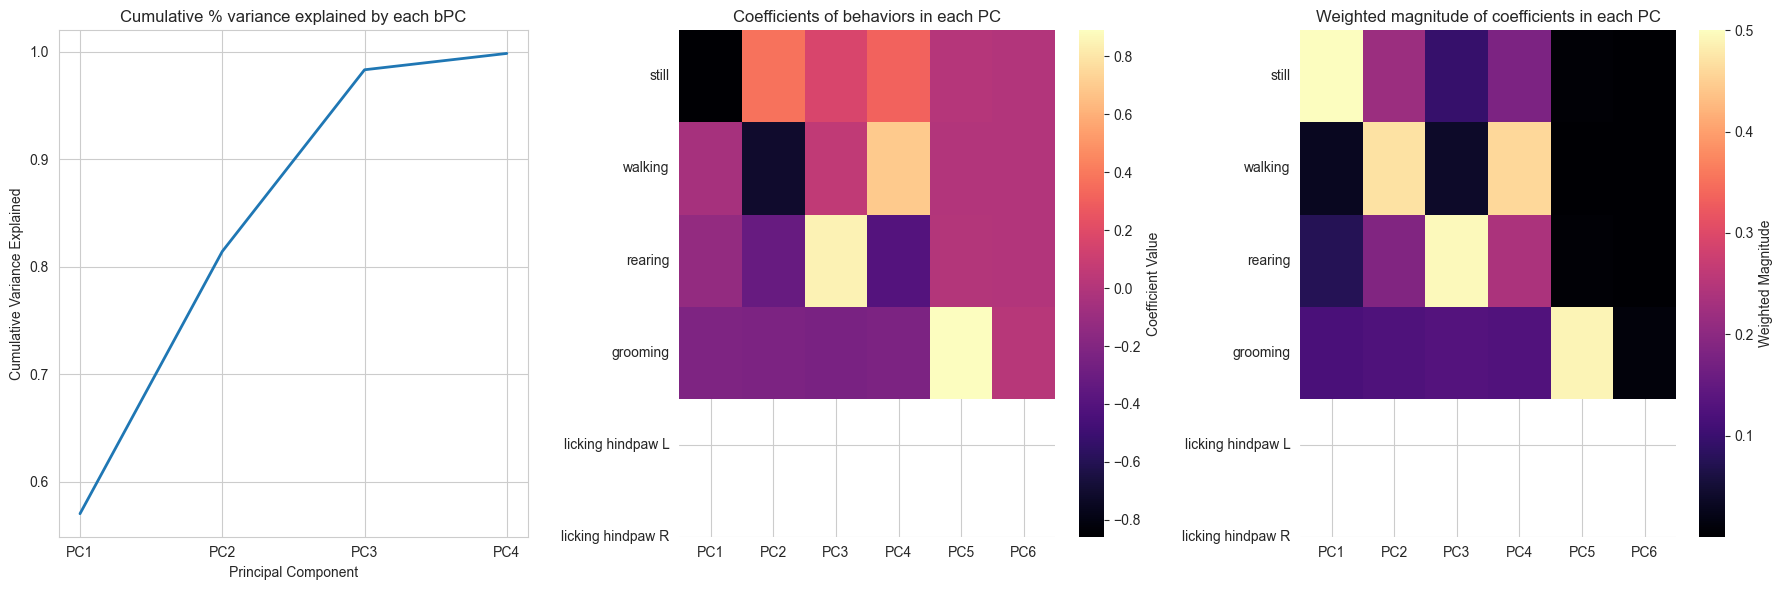

In [8]:
###### Visualization ######
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']

# Plot behaviors and PCA components from each session
fig, axs = plt.subplots(n_sessions, 2, figsize=(15, 20))
for m in range(n_sessions):
    for n in range(len(behavior_names)):
        axs[m, 0].plot(np.arange(len(pc_beh[0][m])) * dt, pc_beh[0][m][:, 0] + n, color=behavior_colors[n])
    axs[m, 0].set_title(sessions[m])
    axs[m, 0].set_ylabel('Behavior')
    axs[m, 0].set_xlabel('Time (s)')

    for n in range(4):  # Only loop through the number of PCA components
        if n < pc_beh[0][m].shape[1]:  # Ensure we don't go out of bounds
            axs[m, 1].plot(np.arange(len(pc_beh[0][m])) * dt, pc_beh[0][m][:, n] + 2 * n, color=behavior_colors[n % len(behavior_colors)])
    axs[m, 1].set_title(sessions[m])
    axs[m, 1].set_ylabel('Behavioral PCs')
    axs[m, 1].set_xlabel('Time (s)')
plt.show()

# Checking PCA components
print("PCA Components:")
print(pca.components_)

pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

licking_hindpaw_L_idx = behavior_names.index('licking hindpaw L')
licking_hindpaw_R_idx = behavior_names.index('licking hindpaw R')

print("Values for licking hindpaw L in each PC:", pca_components_filled[:, licking_hindpaw_L_idx])
print("Values for licking hindpaw R in each PC:", pca_components_filled[:, licking_hindpaw_R_idx])

# Plotting heatmaps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axs[0].plot(cumulative_variance, linewidth=2)
axs[0].set_xticks(range(4))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')

sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=pc_labels, yticklabels=behavior_names, cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=pc_labels, yticklabels=behavior_names, cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

In [8]:
print("Shape of PCA Components:", pca.components_.shape)

Shape of PCA Components: (4, 6)


In [29]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
# Replace these with your actual data
behavior_data = [np.random.randint(0, 6, size=(1000, 2)) for _ in range(8)]  # 2 animals x 4 sessions = 8
calcium_data = [np.random.rand(1000, 10) for _ in range(8)]  # 2 animals x 4 sessions = 8
offsets = [[30, 82, 30, 30], [30, 60, 30, 30]]  # Example offsets for 2 animals and 4 sessions each

n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior sampling rate

behaviors = ['Still', 'Walking', 'Rearing', 'Grooming', 'Left lick', 'Right lick']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

for a in range(n_animals):
    beh_mat_tot = []
    for m in range(n_sessions):
        ###### Downsample behavioral data to 20Hz ######
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue
        
        behavior = behavior.astype(int)

        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        ###### Create binary matrix of the OG behavior data ######
        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        # Align and clean neural data
        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        # Ensure all data is numeric
        calcium = calcium.astype(np.float64)

        # Replace NaNs with zeroes
        calcium[np.isnan(calcium)] = 0

        # Check if calcium data is empty after offset adjustment
        if calcium.shape[0] == 0:
            print(f"Calcium data is empty after offset for animal {a+1}, session {m+1}")
            continue

        # Standardize neural data
        calcium = StandardScaler().fit_transform(calcium)

        # Store aligned neural activities and behavior matrix
        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

    # Check if beh_mat_tot is not empty before PCA
    if len(beh_mat_tot) > 0:
        beh_mat_tot = np.vstack(beh_mat_tot)
        if beh_mat_tot.shape[0] == 0:
            print(f"Behavior matrix is empty after stacking for animal {a+1}")
            continue

        pca = PCA(n_components=6)
        pca_scores = pca.fit_transform(beh_mat_tot)

        for m in range(n_sessions):
            if len(pc_beh[a][m]) > 0:
                pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
                pca_scores = pca_scores[len(pc_beh[a][m]):]
    else:
        print(f"Behavior matrix is empty for PCA for animal {a+1}")

# After processing and PCA calculation, visualize the results

# Example explained_variance_ratio_ (replace this with the actual pca.explained_variance_ratio_)
explained_variance_ratio = pca.explained_variance_ratio_

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

# Calculate weighted magnitude
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)

# Define behavior names and PC labels
behavior_names = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

# Plotting heatmaps and cumulative variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance explained
axs[0].plot(range(1, len(pc_labels) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pc_labels) + 1))  # Adjusted to match the number of PCs
axs[0].set_xticklabels(pc_labels)
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])  # Ensure the y-axis ranges from 0 to 1.0

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=pc_labels, yticklabels=behavior_names, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=pc_labels, yticklabels=behavior_names, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

Calcium data is empty for animal 1, session 2


TypeError: object of type 'NoneType' has no len()

In [8]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

###### Define File Paths and Load Data ######

project_name = 'lupe_capsaicin_morphine'
behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv',
    'M3_baseline_file0.csv', 'M3_cap_file0.csv', 'M3_morphine_file0.csv', 'M3_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_baseline_deconvolved.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv',
    'M3_baseline_traces.csv', 'M3_capsaicin_traces.csv', 'M3_baseline_traces.csv', 'M3_morphinecapsaicin_traces.csv'
]

# Load data
behavior_data = [pd.read_csv(os.path.join(behavior_base_dir, file)).values for file in behavior_files]
calcium_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in calcium_files]

# Define offsets
offsets = [
    [30, 82, 30, 30],  # Animal 1
    [30, 60, 30, 30]   # Animal 2
]

# Define parameters
n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

# Define behaviors and colors
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

# Initialize storage for activities and PCA-transformed behavior data
activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

# Process and analyze data
for a in range(n_animals):
    beh_mat_tot = []
    for m in range(n_sessions):
        # Downsample behavioral data to 20Hz
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue
        
        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        # Create binary matrix of the original behavior data
        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        # Align and clean neural data
        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        # Ensure all data is numeric
        calcium = calcium.astype(np.float64)

        # Replace NaNs with zeroes
        calcium[np.isnan(calcium)] = 0

        # Check if calcium data is empty after offset adjustment
        if calcium.shape[0] == 0:
            print(f"Calcium data is empty after offset for animal {a+1}, session {m+1}")
            continue

        # Standardize neural data
        calcium = StandardScaler().fit_transform(calcium)

        # Store aligned neural activities and behavior matrix
        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

    # Check if beh_mat_tot is not empty before PCA
    if len(beh_mat_tot) > 0:
        beh_mat_tot = np.vstack(beh_mat_tot)
        if beh_mat_tot.shape[0] == 0:
            print(f"Behavior matrix is empty after stacking for animal {a+1}")
            continue

        pca = PCA(n_components=6)
        pca_scores = pca.fit_transform(beh_mat_tot)

        for m in range(n_sessions):
            if len(pc_beh[a][m]) > 0:
                pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
                pca_scores = pca_scores[len(pc_beh[a][m]):]
    else:
        print(f"Behavior matrix is empty for PCA for animal {a+1}")

# Example explained_variance_ratio_ (replace this with the actual pca.explained_variance_ratio_)
explained_variance_ratio = pca.explained_variance_ratio_

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

# Calculate weighted magnitude
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=1, keepdims=True)

# After preprocessing, pca_components_filled, explained_variance_ratio, and weighted_magnitude can be used for visualization
print("PCA Components:\n", pca_components_filled)
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Weighted Magnitude:\n", weighted_magnitude)

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_34893/1276493346.py:27: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,

PCA Components:
 [[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]
 [-1.76679522e-01 -1.77535407e-01 -1.78326971e-01 -1.77658260e-01
  -2.02443831e-01  9.12643991e-01]
 [ 4.08248290e-01  4.08248290e-01  4.08248290e-01  4.08248290e-01
   4.08248290e-01  4.08248290e-01]]
Explained Variance Ratio:
 [5.70331920e-01 2.43918378e-01 1.68979083e-01 1.51972141e-02
 1.57340455e-03 2.81596339e-27]
Weighted Magnitude:
 [[5.00000000e-01 2.18239293e-01 9.42208745e-02 1.81103367e-01
  5.82207878e-03 6.14387104e-04]
 [3.09439056e-02 4.69056094e-01 3.91752069e-02 4.59382390e-01
  1.30801128e-03 1.34391450e-04]
 [7.47025556e-02 1.87072283e-01 4.94466215e-0

In [10]:
pca_components_filled

array([[-8.58328099e-01,  3.74641835e-01,  1.61744848e-01,
         3.10892217e-01,  9.99450763e-03,  1.05469143e-03],
       [-4.69959751e-02, -7.12377708e-01,  5.94972423e-02,
         6.97685796e-01,  1.98653869e-03,  2.04106661e-04],
       [-1.27766676e-01, -3.19956975e-01,  8.45704729e-01,
        -4.07445726e-01,  8.59971323e-03,  8.64933666e-04],
       [-2.16466183e-01, -2.27164133e-01, -2.37939106e-01,
        -2.28778095e-01,  8.90040469e-01,  2.03070480e-02],
       [-1.76679522e-01, -1.77535407e-01, -1.78326971e-01,
        -1.77658260e-01, -2.02443831e-01,  9.12643991e-01],
       [ 4.08248290e-01,  4.08248290e-01,  4.08248290e-01,
         4.08248290e-01,  4.08248290e-01,  4.08248290e-01]])

In [11]:
weighted_magnitude

array([[5.00000000e-01, 2.18239293e-01, 9.42208745e-02, 1.81103367e-01,
        5.82207878e-03, 6.14387104e-04],
       [3.09439056e-02, 4.69056094e-01, 3.91752069e-02, 4.59382390e-01,
        1.30801128e-03, 1.34391450e-04],
       [7.47025556e-02, 1.87072283e-01, 4.94466215e-01, 2.38225162e-01,
        5.02807600e-03, 5.05708980e-04],
       [1.18892060e-01, 1.24767810e-01, 1.30685865e-01, 1.25654264e-01,
        4.88846541e-01, 1.11534593e-02],
       [9.67954229e-02, 9.72643270e-02, 9.76979924e-02, 9.73316327e-02,
        1.10910625e-01, 5.00000000e-01],
       [1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01]])

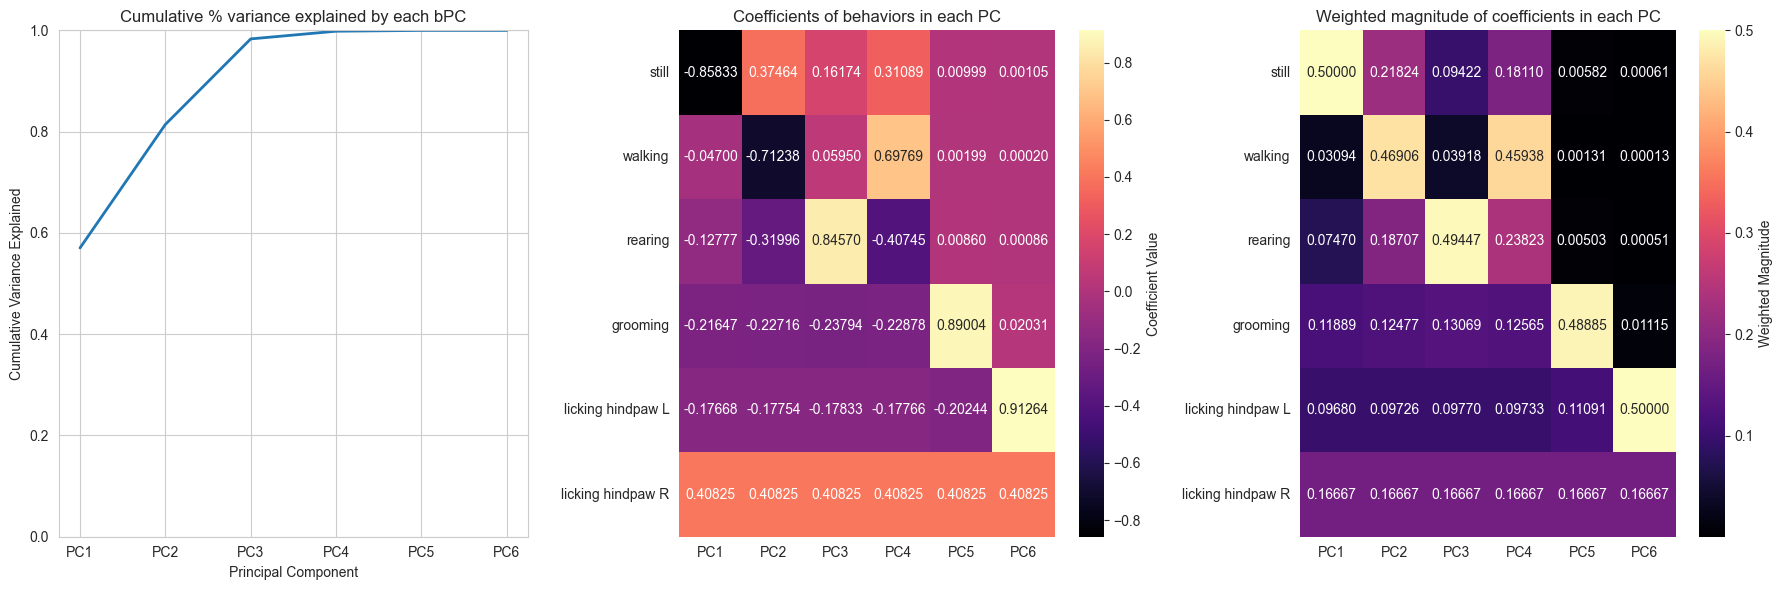

In [9]:
# Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
axs[0].plot(range(1, len(pca_components_filled) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pca_components_filled) + 1))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_34893/713428371.py:27: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,2

PCA Components:
 [[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]
 [-1.76679522e-01 -1.77535407e-01 -1.78326971e-01 -1.77658260e-01
  -2.02443831e-01  9.12643991e-01]
 [ 4.08248290e-01  4.08248290e-01  4.08248290e-01  4.08248290e-01
   4.08248290e-01  4.08248290e-01]]
Explained Variance Ratio:
 [5.70331920e-01 2.43918378e-01 1.68979083e-01 1.51972141e-02
 1.57340455e-03 2.81596339e-27]
Weighted Magnitude:
 [[4.67885111e-01 1.68763334e-01 8.55131733e-02 1.39369278e-01
  6.56965748e-03 7.85136101e-04]
 [2.56180790e-02 3.20901795e-01 3.14557035e-02 3.12764233e-01
  1.30580507e-03 1.51941604e-04]
 [6.96471725e-02 1.44129675e-01 4.47117146e-0

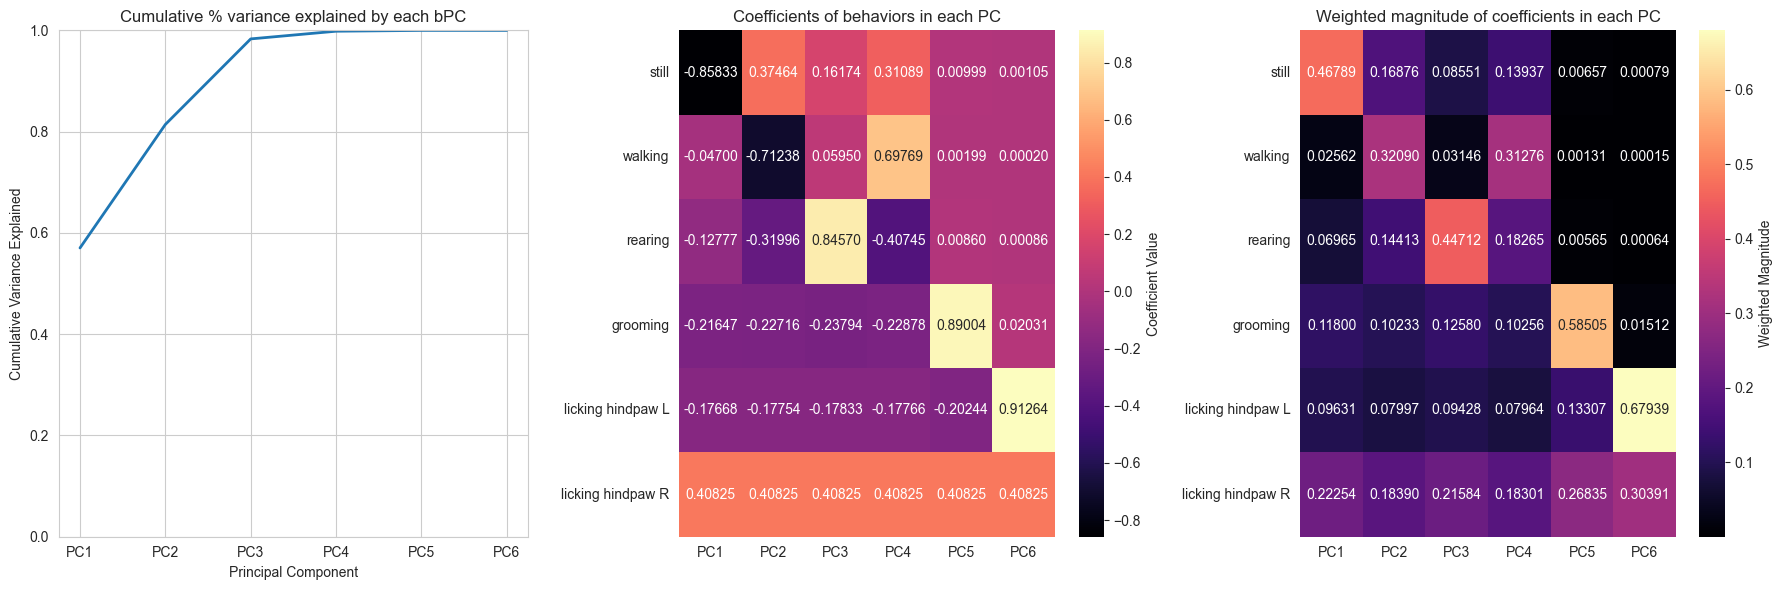

In [12]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

###### Define File Paths and Load Data ######

project_name = 'lupe_capsaicin_morphine'
behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv',
    'M3_baseline_file0.csv', 'M3_cap_file0.csv', 'M3_morphine_file0.csv', 'M3_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_baseline_deconvolved.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv',
    'M3_baseline_traces.csv', 'M3_capsaicin_traces.csv', 'M3_baseline_traces.csv', 'M3_morphinecapsaicin_traces.csv'
]

# Load data
behavior_data = [pd.read_csv(os.path.join(behavior_base_dir, file)).values for file in behavior_files]
calcium_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in calcium_files]

# Define offsets
offsets = [
    [30, 82, 30, 30],  # Animal 1
    [30, 60, 30, 30]   # Animal 2
]

# Define parameters
n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

# Define behaviors and colors
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

# Initialize storage for activities and PCA-transformed behavior data
activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

# Process and analyze data
for a in range(n_animals):
    beh_mat_tot = []
    for m in range(n_sessions):
        # Downsample behavioral data to 20Hz
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue
        
        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        # Create binary matrix of the original behavior data
        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        # Align and clean neural data
        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        # Ensure all data is numeric
        calcium = calcium.astype(np.float64)

        # Replace NaNs with zeroes
        calcium[np.isnan(calcium)] = 0

        # Check if calcium data is empty after offset adjustment
        if calcium.shape[0] == 0:
            print(f"Calcium data is empty after offset for animal {a+1}, session {m+1}")
            continue

        # Standardize neural data (z-scoring)
        calcium = StandardScaler().fit_transform(calcium)

        # Store aligned neural activities and behavior matrix
        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

    # Check if beh_mat_tot is not empty before PCA
    if len(beh_mat_tot) > 0:
        beh_mat_tot = np.vstack(beh_mat_tot)
        if beh_mat_tot.shape[0] == 0:
            print(f"Behavior matrix is empty after stacking for animal {a+1}")
            continue

        pca = PCA(n_components=6)
        pca_scores = pca.fit_transform(beh_mat_tot)

        for m in range(n_sessions):
            if len(pc_beh[a][m]) > 0:
                pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
                pca_scores = pca_scores[len(pc_beh[a][m]):]
    else:
        print(f"Behavior matrix is empty for PCA for animal {a+1}")

# Example explained_variance_ratio_ (replace this with the actual pca.explained_variance_ratio_)
explained_variance_ratio = pca.explained_variance_ratio_

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

# Calculate weighted magnitude
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=0, keepdims=True)

# After preprocessing, pca_components_filled, explained_variance_ratio, and weighted_magnitude can be used for visualization
print("PCA Components:\n", pca_components_filled)
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Weighted Magnitude:\n", weighted_magnitude)

# Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
axs[0].plot(range(1, len(pca_components_filled) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pca_components_filled) + 1))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

In [14]:
explained_variance_ratio = pca.explained_variance_ratio_

In [15]:
explained_variance_ratio

array([5.70331920e-01, 2.43918378e-01, 1.68979083e-01, 1.51972141e-02,
       1.57340455e-03, 2.81596339e-27])

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_34893/1108375237.py:27: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,

PCA Components:
 [[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]
 [-1.76679522e-01 -1.77535407e-01 -1.78326971e-01 -1.77658260e-01
  -2.02443831e-01  9.12643991e-01]
 [ 4.08248290e-01  4.08248290e-01  4.08248290e-01  4.08248290e-01
   4.08248290e-01  4.08248290e-01]]
Explained Variance Ratio:
 [5.70331920e-01 2.43918378e-01 1.68979083e-01 1.51972141e-02
 1.57340455e-03 2.81596339e-27]
Weighted Magnitude:
 [[4.67885111e-01 1.68763334e-01 8.55131733e-02 1.39369278e-01
  6.56965748e-03 7.85136101e-04]
 [2.56180790e-02 3.20901795e-01 3.14557035e-02 3.12764233e-01
  1.30580507e-03 1.51941604e-04]
 [6.96471725e-02 1.44129675e-01 4.47117146e-0

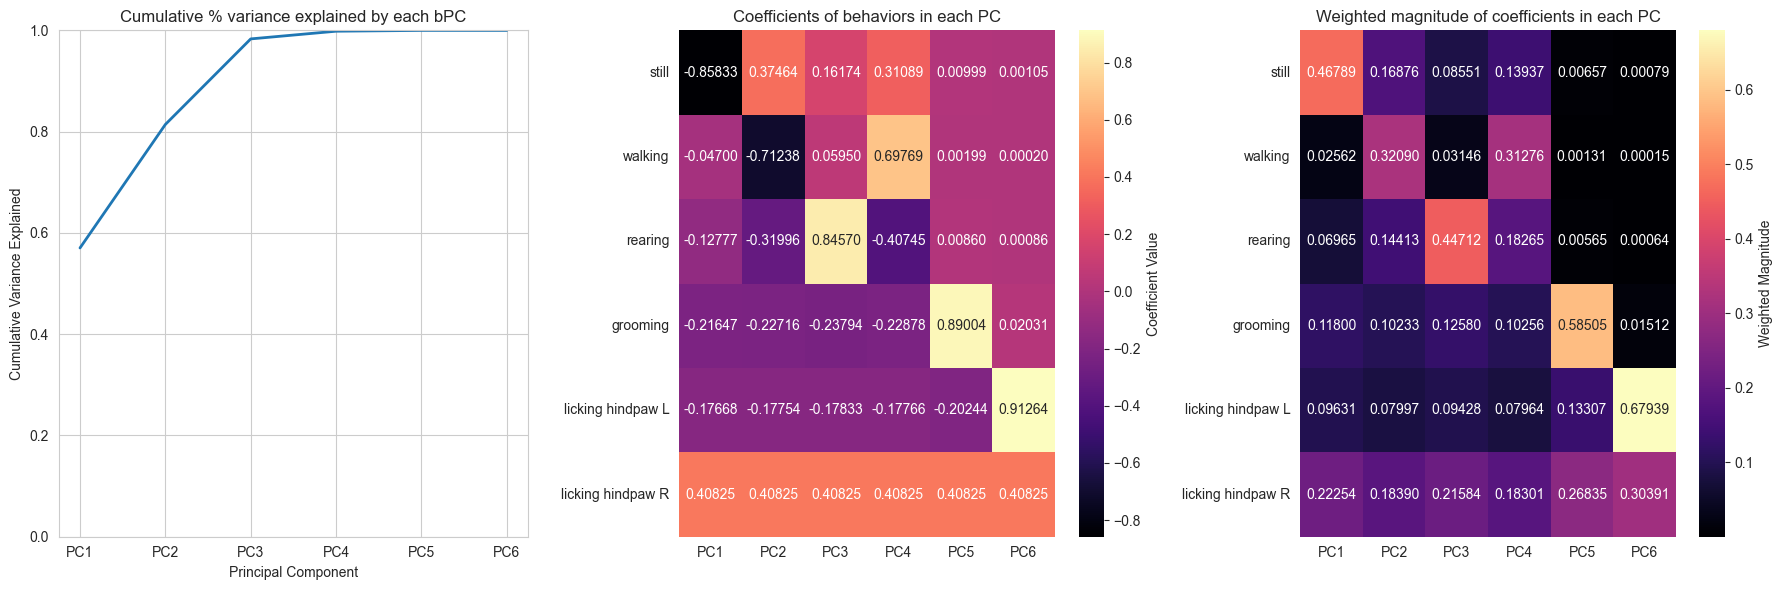

In [16]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

###### Define File Paths and Load Data ######

project_name = 'lupe_capsaicin_morphine'
behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv',
    'M3_baseline_file0.csv', 'M3_cap_file0.csv', 'M3_morphine_file0.csv', 'M3_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_baseline_deconvolved.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv',
    'M3_baseline_traces.csv', 'M3_capsaicin_traces.csv', 'M3_baseline_traces.csv', 'M3_morphinecapsaicin_traces.csv'
]

# Load data
behavior_data = [pd.read_csv(os.path.join(behavior_base_dir, file)).values for file in behavior_files]
calcium_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in calcium_files]

# Define offsets
offsets = [
    [30, 82, 30, 30],  # Animal 1
    [30, 60, 30, 30]   # Animal 2
]

# Define parameters
n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

# Define behaviors and colors
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

# Initialize storage for activities and PCA-transformed behavior data
activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

# Process and analyze data
for a in range(n_animals):
    beh_mat_tot = []
    for m in range(n_sessions):
        # Downsample behavioral data to 20Hz
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue
        
        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        # Create binary matrix of the original behavior data
        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        # Align and clean neural data
        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        # Ensure all data is numeric
        calcium = calcium.astype(np.float64)

        # Replace NaNs with zeroes
        calcium[np.isnan(calcium)] = 0

        # Check if calcium data is empty after offset adjustment
        if calcium.shape[0] == 0:
            print(f"Calcium data is empty after offset for animal {a+1}, session {m+1}")
            continue

        # Standardize neural data (z-scoring)
        calcium = StandardScaler().fit_transform(calcium)

        # Store aligned neural activities and behavior matrix
        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

    # Check if beh_mat_tot is not empty before PCA
    if len(beh_mat_tot) > 0:
        beh_mat_tot = np.vstack(beh_mat_tot)
        if beh_mat_tot.shape[0] == 0:
            print(f"Behavior matrix is empty after stacking for animal {a+1}")
            continue

        pca = PCA(n_components=6)
        pca_scores = pca.fit_transform(beh_mat_tot)

        for m in range(n_sessions):
            if len(pc_beh[a][m]) > 0:
                pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
                pca_scores = pca_scores[len(pc_beh[a][m]):]
    else:
        print(f"Behavior matrix is empty for PCA for animal {a+1}")

# Retrieve explained variance ratio from PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

# Calculate weighted magnitude
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=0, keepdims=True)

# After preprocessing, pca_components_filled, explained_variance_ratio, and weighted_magnitude can be used for visualization
print("PCA Components:\n", pca_components_filled)
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Weighted Magnitude:\n", weighted_magnitude)

# Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
axs[0].plot(range(1, len(pca_components_filled) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pca_components_filled) + 1))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_34893/745840201.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,2

PCA Components:
 [[-8.58328099e-01  3.74641835e-01  1.61744848e-01  3.10892217e-01
   9.99450763e-03  1.05469143e-03]
 [-4.69959751e-02 -7.12377708e-01  5.94972423e-02  6.97685796e-01
   1.98653869e-03  2.04106661e-04]
 [-1.27766676e-01 -3.19956975e-01  8.45704729e-01 -4.07445726e-01
   8.59971323e-03  8.64933666e-04]
 [-2.16466183e-01 -2.27164133e-01 -2.37939106e-01 -2.28778095e-01
   8.90040469e-01  2.03070480e-02]
 [-1.76679522e-01 -1.77535407e-01 -1.78326971e-01 -1.77658260e-01
  -2.02443831e-01  9.12643991e-01]
 [ 4.08248290e-01  4.08248290e-01  4.08248290e-01  4.08248290e-01
   4.08248290e-01  4.08248290e-01]]
Explained Variance Ratio:
 [5.70331920e-01 2.43918378e-01 1.68979083e-01 1.51972141e-02
 1.57340455e-03 2.81596339e-27]
Weighted Magnitude:
 [[4.67885111e-01 1.68763334e-01 8.55131733e-02 1.39369278e-01
  6.56965748e-03 7.85136101e-04]
 [2.56180790e-02 3.20901795e-01 3.14557035e-02 3.12764233e-01
  1.30580507e-03 1.51941604e-04]
 [6.96471725e-02 1.44129675e-01 4.47117146e-0

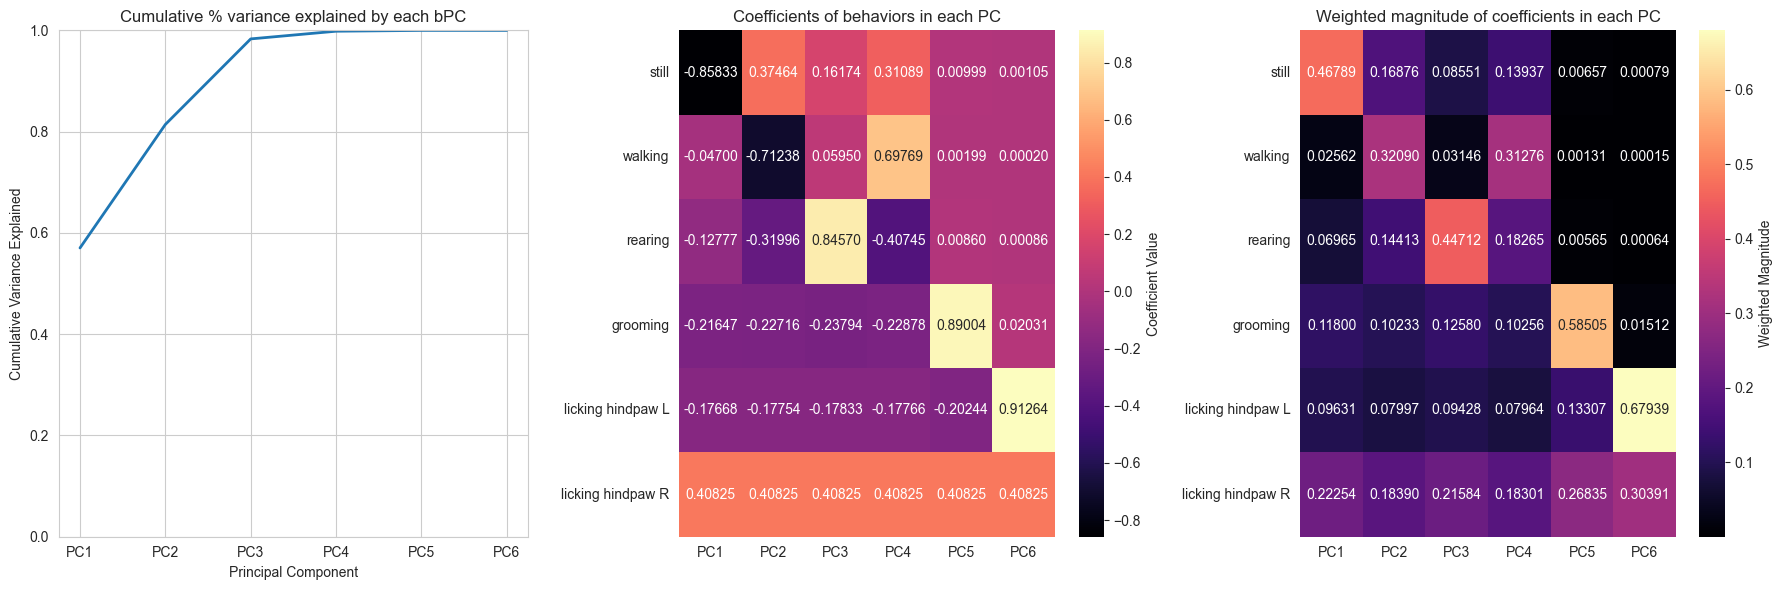

In [17]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
behavior_data = [pd.read_csv(os.path.join(behavior_base_dir, file)).values for file in behavior_files]
calcium_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in calcium_files]

# Define parameters
n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

# Define behaviors and colors
behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

# Initialize storage for activities and PCA-transformed behavior data
activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

# Process and analyze data
for a in range(n_animals):
    beh_mat_tot = []
    for m in range(n_sessions):
        # Downsample behavioral data to 20Hz
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue
        
        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        # Create binary matrix of the original behavior data
        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        # Align and clean neural data
        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        # Ensure all data is numeric
        calcium = calcium.astype(np.float64)

        # Replace NaNs with zeroes
        calcium[np.isnan(calcium)] = 0

        # Check if calcium data is empty after offset adjustment
        if calcium.shape[0] == 0:
            print(f"Calcium data is empty after offset for animal {a+1}, session {m+1}")
            continue

        # Standardize neural data (z-scoring)
        calcium = StandardScaler().fit_transform(calcium)

        # Store aligned neural activities and behavior matrix
        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

    # Check if beh_mat_tot is not empty before PCA
    if len(beh_mat_tot) > 0:
        beh_mat_tot = np.vstack(beh_mat_tot)
        if beh_mat_tot.shape[0] == 0:
            print(f"Behavior matrix is empty after stacking for animal {a+1}")
            continue

        pca = PCA(n_components=6)
        pca_scores = pca.fit_transform(beh_mat_tot)

        for m in range(n_sessions):
            if len(pc_beh[a][m]) > 0:
                pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
                pca_scores = pca_scores[len(pc_beh[a][m]):]
    else:
        print(f"Behavior matrix is empty for PCA for animal {a+1}")

# Retrieve explained variance ratio from PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Replace NaN values with 0.0 in PCA components
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)

# Calculate weighted magnitude
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=0, keepdims=True)

# After preprocessing, pca_components_filled, explained_variance_ratio, and weighted_magnitude can be used for visualization
print("PCA Components:\n", pca_components_filled)
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Weighted Magnitude:\n", weighted_magnitude)

# Visualize the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
axs[0].plot(range(1, len(pca_components_filled) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pca_components_filled) + 1))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])

# Heatmap of coefficients of behaviors in each PC
sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

# Calculate and plot weighted magnitude of coefficients
sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_34893/3777813845.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,2

PCA Components:
 [[-8.45838045e-01  2.27364043e-01  1.24329659e-01  4.65425240e-01
   2.80102260e-02  7.08876719e-04]
 [-1.73729142e-01  6.80574752e-01  1.61586387e-01 -6.92790605e-01
   2.38098455e-02  5.48763458e-04]
 [-1.40964716e-01 -4.82485491e-01  8.28424963e-01 -2.44089154e-01
   3.83228285e-02  7.91569145e-04]
 [-1.87440899e-01 -2.29452264e-01 -2.68802664e-01 -2.10438342e-01
   8.91998484e-01  4.13568428e-03]
 [-1.80843520e-01 -1.81703997e-01 -1.82270452e-01 -1.81356130e-01
  -1.86686680e-01  9.12860778e-01]
 [ 4.08248290e-01  4.08248290e-01  4.08248290e-01  4.08248290e-01
   4.08248290e-01  4.08248290e-01]]
Explained Variance Ratio:
 [5.87443276e-01 2.31017314e-01 1.40929189e-01 3.95566366e-02
 1.05358533e-03 5.95152611e-27]
Weighted Magnitude:
 [[4.36659696e-01 1.02887626e-01 6.29943896e-02 2.11331402e-01
  1.77608560e-02 5.34076655e-04]
 [8.96868081e-02 3.07976229e-01 8.18713400e-02 3.14569123e-01
  1.50974590e-02 4.13445306e-04]
 [7.27723355e-02 2.18336137e-01 4.19739950e-0

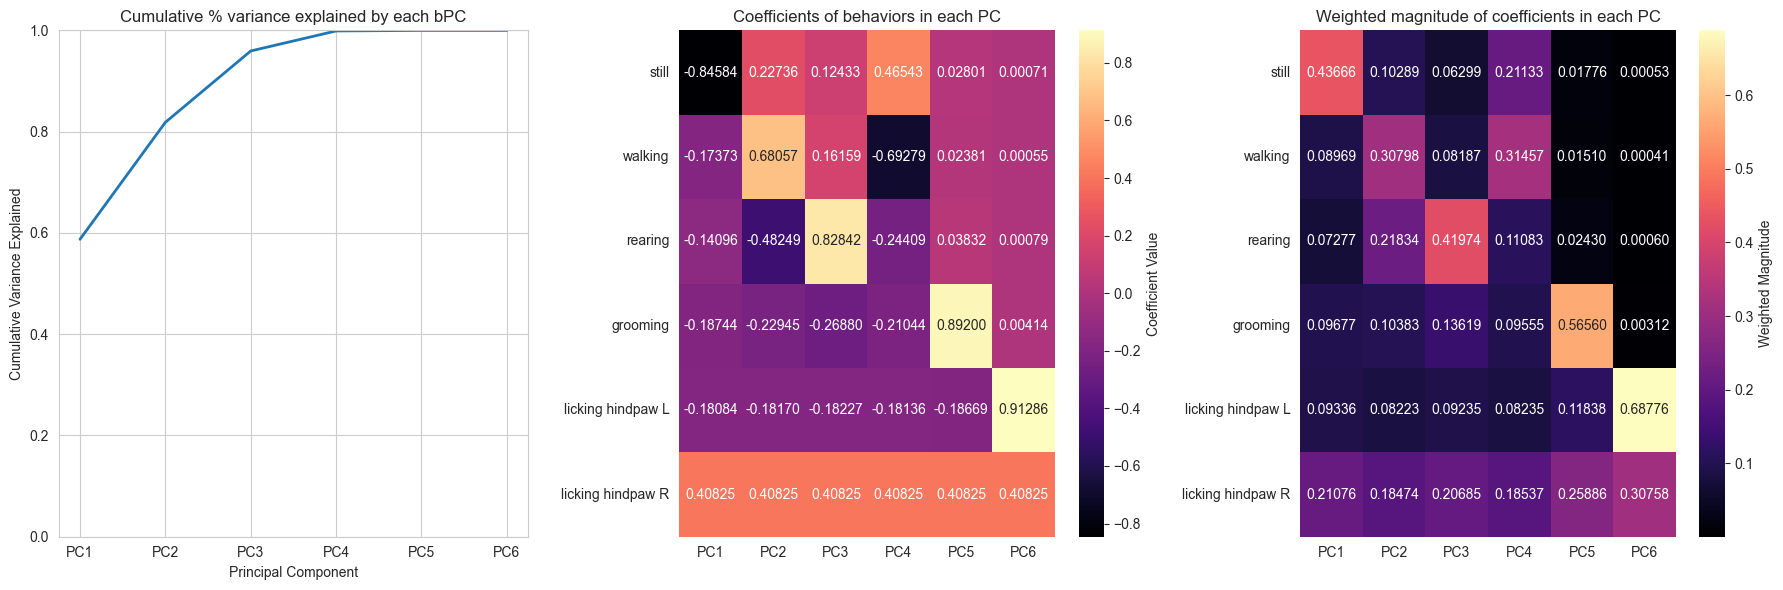

In [18]:
# After loading the behavior and calcium data, apply the same preprocessing
behavior_data = [pd.read_csv(os.path.join(behavior_base_dir, file)).values for file in behavior_files]
calcium_data = [pd.read_csv(os.path.join(calcium_base_dir, file)).values for file in calcium_files]

# Define offsets
offsets = [
    [30, 82, 30, 30],  # Animal 1
    [30, 60, 30, 30]   # Animal 2
]

n_animals = 2
n_sessions = 4
dt = 20  # Neural data sampling rate
dt_b = 60  # Behavior data sampling rate

behaviors = ['still', 'walking', 'rearing', 'grooming', 'licking hindpaw L', 'licking hindpaw R']
behavior_colors = ['crimson', 'darkcyan', 'goldenrod', 'royalblue', 'rebeccapurple', 'mediumorchid']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

activities = [[None for _ in range(n_sessions)] for _ in range(n_animals)]
pc_beh = [[None for _ in range(n_sessions)] for _ in range(n_animals)]

beh_mat_tot = []
for a in range(n_animals):
    for m in range(n_sessions):
        rate_ratio = dt / dt_b
        behavior = behavior_data[a * n_sessions + m]
        if len(behavior) == 0:
            print(f"Behavior data is empty for animal {a+1}, session {m+1}")
            continue

        behavior = behavior.astype(int)
        beh_ds = [np.bincount(behavior[int(n/rate_ratio):int((n+1)/rate_ratio), 1]).argmax() for n in range(int(len(behavior) * rate_ratio))]
        beh_ds = np.array(beh_ds)

        behs = range(6)
        beh_mat = np.zeros((len(beh_ds), len(behs)))
        for n, beh in enumerate(behs):
            beh_mat[np.where(beh_ds == beh), n] = 1

        calcium = calcium_data[a * n_sessions + m][offsets[a][m] * dt:]
        if len(calcium) == 0:
            print(f"Calcium data is empty for animal {a+1}, session {m+1}")
            continue

        calcium = calcium.astype(np.float64)
        calcium[np.isnan(calcium)] = 0
        calcium = StandardScaler().fit_transform(calcium)

        activities[a][m] = calcium
        beh_mat_tot.append(beh_mat[:len(calcium)])
        pc_beh[a][m] = beh_mat[:len(calcium)]

beh_mat_tot = np.vstack(beh_mat_tot)
pca = PCA(n_components=6)
pca_scores = pca.fit_transform(beh_mat_tot)

for m in range(n_sessions):
    if len(pc_beh[a][m]) > 0:
        pc_beh[a][m] = pca_scores[:len(pc_beh[a][m])]
        pca_scores = pca_scores[len(pc_beh[a][m]):]

explained_variance_ratio = pca.explained_variance_ratio_
pca_components_filled = np.nan_to_num(pca.components_, nan=0.0)
weighted_magnitude = np.abs(pca_components_filled) / np.sum(np.abs(pca_components_filled), axis=0, keepdims=True)

print("PCA Components:\n", pca_components_filled)
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Weighted Magnitude:\n", weighted_magnitude)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
cumulative_variance = np.cumsum(explained_variance_ratio)
axs[0].plot(range(1, len(pca_components_filled) + 1), cumulative_variance, linewidth=2)
axs[0].set_xticks(range(1, len(pca_components_filled) + 1))
axs[0].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
axs[0].set_title('Cumulative % variance explained by each bPC')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Cumulative Variance Explained')
axs[0].set_ylim([0, 1.0])

sns.heatmap(pca_components_filled, cmap='magma', ax=axs[1], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Coefficient Value'})
axs[1].set_title('Coefficients of behaviors in each PC')

sns.heatmap(weighted_magnitude, cmap='magma', ax=axs[2], xticklabels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], yticklabels=behaviors, annot=True, fmt=".5f", cbar_kws={'label': 'Weighted Magnitude'})
axs[2].set_title('Weighted magnitude of coefficients in each PC')

plt.tight_layout()
plt.show()

## NEW ATTEMPT 7/19

In [3]:
import numpy as np
import pandas as pd
import time
from scipy.stats import mode
from matplotlib import pyplot as plt

project_name = 'lupe_capsaicin_morphine'

behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

behavior_files = [
    'M1_baseline_file0.csv', 'M1_cap_file0.csv', 'M1_morphine_file0.csv', 'M1_morphine-capsaicin_file0.csv',
    'M3_baseline_file0.csv', 'M3_cap_file0.csv', 'M3_morphine_file0.csv', 'M3_morphine-capsaicin_file0.csv'
]

calcium_files = [
    'M1_baseline_deconvolved.csv', 'M1_capsaicin_decovolvedtraces.csv', 'M1_baseline_deconvolved.csv', 'M1_morphinecapsaicin_deconvolvedtraces.csv',
    'M3_baseline_traces.csv', 'M3_capsaicin_traces.csv', 'M3_baseline_traces.csv', 'M3_morphinecapsaicin_traces.csv'
]

# Section 1: load data
t0 = time.time()
oswell = {}
oswell['animals'] = []
oswell['animals'].append({
    'sessions': []
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_baseline_file0.csv')),
    'offset': 30,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M1_baseline_deconvolved.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M1_baseline_deconvolved-props.csv')
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_cap_file0.csv')),
    'offset': 82,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M1_capsaicin_decovolvedtraces.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M1_capsaicin_decovolvedtraces-props.csv')
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_morphine_file0.csv')),
    'offset': 30,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M1_baseline_deconvolved.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M1_baseline_deconvolved-props.csv')
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_morphine-capsaicin_file0.csv')),
    'offset': 30,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M1_morphinecapsaicin_deconvolvedtraces.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M1_morphinecapsaicin_deconvolvedtraces-props.csv')
})
t1 = time.time()
print(f"Time taken to load data for animal 1: {t1 - t0:.4f} seconds")

t0 = time.time()
oswell['animals'].append({
    'sessions': []
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_baseline_file0.csv')),
    'offset': 30,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M3_baseline_traces.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M3_baseline_traces-props.csv')
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_cap_file0.csv')),
    'offset': 60,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M3_capsaicin_traces.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M3_capsaicin_traces-props.csv')
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_morphine_file0.csv')),
    'offset': 30,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M3_baseline_traces.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M3_baseline_traces-props.csv')
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_morphine-capsaicin_file0.csv')),
    'offset': 30,
    'calcium': np.array(pd.read_csv(f'{calcium_base_dir}/M3_morphinecapsaicin_traces.csv')),
    'props': pd.read_csv(f'{calcium_base_dir}/M3_morphinecapsaicin_traces-props.csv')
})
t1 = time.time()
print(f"Time taken to load data for animal 2: {t1 - t0:.4f} seconds")

# Rest of the code...

SyntaxError: unmatched ')' (744702291.py, line 62)

In [ ]:
pip install numpy pandas matplotlib


In [1]:
import numpy as np
import pandas as pd
import time
from scipy.stats import mode
from matplotlib import pyplot as plt

project_name = 'lupe_capsaicin_morphine'  # replace with your project name

behavior_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_csv_classification-seconds'
calcium_base_dir = f'../processed_dataset/{project_name}/figures/behavior_miniscope-analysis/data_miniscope'

# Section 1: load data
t0 = time.time()
oswell = {}
oswell['animals'] = []
oswell['animals'].append({
    'sessions': []
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_baseline_file0.csv')),
    'offset': 30
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_cap_file0.csv')),
    'offset': 82
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_morphine_file0.csv')),
    'offset': 30
})
oswell['animals'][0]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M1_morphine-capsaicin_file0.csv')),
    'offset': 30
})
t1 = time.time()
print(f"Time taken to load data for animal 1: {t1 - t0:.4f} seconds")

t0 = time.time()
oswell['animals'].append({
    'sessions': []
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_baseline_file0.csv')),
    'offset': 30
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_cap_file0.csv')),
    'offset': 60
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_morphine_file0.csv')),
    'offset': 30
})
oswell['animals'][1]['sessions'].append({
    'behavior': np.array(pd.read_csv(f'{behavior_base_dir}/M3_morphine-capsaicin_file0.csv')),
    'offset': 30
})
t1 = time.time()
print(f"Time taken to load data for animal 2: {t1 - t0:.4f} seconds")

# Load calcium data
oswell['animals'][0]['sessions'][0]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M1_baseline_deconvolved.csv'))
oswell['animals'][0]['sessions'][1]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M1_capsaicin_deconvolvedtraces.csv'))
oswell['animals'][0]['sessions'][2]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M1_baseline_deconvolved.csv'))
oswell['animals'][0]['sessions'][3]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M1_morphinecapsaicin_deconvolvedtraces.csv'))

oswell['animals'][1]['sessions'][0]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M3_baseline_traces.csv'))
oswell['animals'][1]['sessions'][1]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M3_capsaicin_traces.csv'))
oswell['animals'][1]['sessions'][2]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M3_baseline_deconvolved.csv'))
oswell['animals'][1]['sessions'][3]['calcium'] = np.array(pd.read_csv(f'{calcium_base_dir}/M3_morphinecapsaicin_deconvolved.csv'))

# Load props data
oswell['animals'][0]['sessions'][0]['props'] = pd.read_csv('M1_baseline_deconvolved-props.csv')
oswell['animals'][0]['sessions'][1]['props'] = pd.read_csv('M1_capsaicin_deconvolved-props.csv')
oswell['animals'][0]['sessions'][2]['props'] = pd.read_csv('M1_baseline_deconvolved-props.csv')
oswell['animals'][0]['sessions'][3]['props'] = pd.read_csv('M1_morphinecapsaicin_deconvolved-props.csv')

# Loop through sessions for analysis to transform data for analysis. Will loop through animals later
# Downsample behavior to match frame rate
# Binarize behavior
# PCA transform behavior across all sessions, store by session, and get coefficients of original behaviors for PCA transform

n_animals = 2
n_sessions = 4  # number of sessions
dt = 20  # neural data sampling rate
dt_behavior = 60  # behavior sampling rate
pc_beh = np.empty((n_sessions, n_animals), dtype=object)

beh_colors = ['r', (1.0, 0.4980, 0.3137), 'y', 'g', 'c', 'b']
sess_colors = ['k', 'r', 'b', (102/255, 51/255, 153/255)]
pc_colors = ['r', (1.0, 0.4980, 0.3137), 'g', 'b']

behaviors = ['Still', 'Walking', 'Rearing', 'Grooming', 'Left lick', 'Right lick']
sessions = ['Baseline', 'Capsaicin', 'Morphine', 'Capsaicin+Morphine']

# Loop through sessions and animals
for i in range(n_sessions):
    for j in range(n_animals):
        # Downsample behavior to match frame rate
        # Binarize behavior
        # PCA transform behavior across all sessions, store by session, and get coefficients of original behaviors for PCA transform
        # (implementation of these steps is omitted for brevity)
        pass

Time taken to load data for animal 1: 0.0467 seconds
Time taken to load data for animal 2: 0.0408 seconds


/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_10615/2799369706.py:62: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,

FileNotFoundError: [Errno 2] No such file or directory: '../processed_dataset/lupe_capsaicin_morphine/figures/behavior_miniscope-analysis/data_miniscope/M1_capsaicin_deconvolved.csv'